In [1]:
import numpy as np 
import astropy.constants as c
import os
import csv
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import gc
import math
#list all the constants used
G=c.G.value
M_sun=c.M_sun.value
M_earth=c.M_earth.value
R_sun=c.R_sun.value
R_earth=c.R_earth.value
hour=3600 #s
day=3600*24
e=0.1
t_LC=1765.5 #s

def delta(Rp, Rs): #unit ppm
    delta = (Rp*R_earth / (Rs*R_sun))**2*1e6
    return delta

def SNR(delta,n,sigma_s):
    SNR=delta*n**0.5/sigma_s
    return SNR

def sigma_s(t, sigma_LC, cdppindex): #t/hour
    t_LC=1765.5/hour 

    return sigma_LC*(t/t_LC)**cdppindex

def t_dur(P,Rs,e,a): #hour
    t_dur = P*day*Rs*R_sun*(1-e**2)/(np.pi*a)/hour
    return t_dur

def a(Ms,P):
    a=((G*Ms*M_sun*(P*day)**2)/(4*np.pi**2))**(1/3)
    return a 

def n(t_obs,P): # the unite of t_obs and P is day
    n=t_obs/P
    return n

def f_n(t_obs,P):
    if t_obs <=2*P:
        return 0
    if t_obs> 2*P and t_obs< 3*P:
        return (t_obs/P-2)
    if t_obs>=3*P:
        return 1
    
def f_eff(SNR):
    if SNR <=6:
        return 0
    if SNR >6 and SNR<=12:
        return (SNR-6)/6
    if SNR>12:
        return 1
    
def f_geo(Rp,Rs,a,e):
    f_geo = (Rp*R_earth+Rs*R_sun)/(a*(1-e**2))
    return f_geo


In [6]:
stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_stellar_q17_add_dispersions_reduction_reduction_2020.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_koi_q17_add_dispersions_reduction_reduction_new.csv',sep=',')

focc=pd.read_csv('result/occurrence_rate_tot_2020_2sigma.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']
prad=[]
f=0
R_J=c.R_jup.value/c.R_earth.value
for i in range(0,len(f_occurrence_everyplanet)):
    if koi_table['koi_prad'][f_id[i]]>=0.71*R_J and koi_table['koi_prad'][f_id[i]]<=2.85*R_J and koi_table['koi_period'][f_id[i]]<=10 and koi_table['koi_disposition'][f_id[i]]!='FALSE POSITIVE':
        prad.append(koi_table['koi_prad'][f_id[i]])
        f+=f_occurrence_everyplanet[f_id[i]]
        
std_f=f/(len(prad))**0.5
print(f,std_f,prad,len(prad))

0.039273590915636904 0.004909198864454613 [19.36, 23.28, 8.78, 14.48, 12.05, 26.06, 16.1, 13.25, 16.91, 9.83, 10.62, 20.23, 18.05, 12.74, 8.43, 11.76, 19.1, 29.33, 29.91, 19.45, 12.78, 15.75, 9.0, 20.91, 23.51, 9.66, 13.06, 25.74, 12.14, 12.21, 10.6, 12.04, 22.27, 22.95, 10.96, 10.6, 10.43, 12.73, 11.38, 25.82, 11.94, 13.12, 25.84, 12.91, 16.51, 13.43, 24.39, 8.01, 12.63, 12.21, 14.16, 11.16, 10.63, 16.89, 10.77, 10.07, 11.58, 11.3, 28.94, 19.39, 8.17, 10.05, 13.44, 10.51] 64


In [4]:
print(max(stellar_table['dist']))

56886.2


/home/dyz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars
/home/dyz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in double_scalars


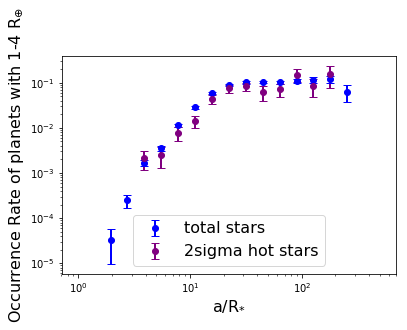

In [18]:
stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_stellar_q17_add_dispersions_reduction_reduction_2020.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_koi_q17_add_dispersions_reduction_reduction_new.csv',sep=',')
bins_period=np.logspace(math.log(0.4,5),math.log(250,5),13,base=5)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  

bins_t=np.logspace(math.log(120,5),math.log(6000,5),25,base=5)



focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/result/occurrence_rate_total.csv')
f_occurrence_everyplanet=focc['occurrence_rate']

bins_a_ratio=np.logspace(math.log(0.8,10),math.log(600,10),20,base=10)
number=50


a_koi_ratio=[] #use a/R_star dimensionless variance to show the correlation
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi_ratio.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value*c.au.value/(koi_table['rad_b2018'][i]*c.R_sun.value))    


f_p=[]
f_p_std=[]
p=[]
p_std=[]
a_ratio=[]
a_ratio_std=[]
#and koi_table['koi_disposition'][j]!='FALSE POSITIVE' \
for i in range(0,len(bins_a_ratio)-1):
    focc_temp=[]
    a_ratio_temp=[]
    for j in range(0,len(f_occurrence_everyplanet)):
        if a_koi_ratio[j]<bins_a_ratio[i+1] and a_koi_ratio[j]>=bins_a_ratio[i] and koi_table['koi_disposition'][j]!='FALSE POSITIVE' \
        and koi_table['koi_prad'][j]<=4 and koi_table['koi_prad'][j]>=1 and koi_table['koi_period'][j]<=365:
            focc_temp.append(f_occurrence_everyplanet[j])
            a_ratio_temp.append(a_koi_ratio[j])
            
    f_p.append(np.sum(focc_temp))
    f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
    a_ratio.append((bins_a_ratio[i+1]+bins_a_ratio[i])/2)
    a_ratio_std.append(np.std(a_ratio_temp))


plt.errorbar(a_ratio,f_p,yerr=f_p_std,fmt="o",color='blue',elinewidth=2,capsize=4,label='total stars') 


stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_stellar_q17_add_dispersions_reduction_reduction_hot_2020.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_koi_q17_add_dispersions_reduction_reduction_2sigma_hot.csv',sep=',')
bins_period=np.logspace(math.log(0.4,5),math.log(250,5),13,base=5)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  
bins_t=np.logspace(math.log(120,5),math.log(6000,5),25,base=5)
focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/result/occurrence_rate_hot_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']
bins_a_ratio=np.logspace(math.log(0.8,10),math.log(600,10),20,base=10)
a_koi_ratio=[] #use a/R_star dimensionless variance to show the correlation
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi_ratio.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value*c.au.value/(koi_table['rad_b2018'][i]*c.R_sun.value))    

f_p=[]
f_p_std=[]
p=[]
p_std=[]
a_ratio=[]
a_ratio_std=[]
# and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' \
for i in range(0,len(a_koi_ratio)-1):
    focc_temp=[]
    a_ratio_temp=[]
    for j in range(0,len(f_occurrence_everyplanet)):
        if a_koi_ratio[f_id[j]]<bins_a_ratio[i+1] and a_koi_ratio[f_id[j]]>=bins_a_ratio[i] and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' \
        and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1 and koi_table['koi_period'][f_id[j]]<=365:
            focc_temp.append(f_occurrence_everyplanet[j])
            a_ratio_temp.append(a_koi_ratio[f_id[j]])
            
    f_p.append(np.sum(focc_temp))
    f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
    a_ratio.append((bins_a_ratio[i+1]+bins_a_ratio[i])/2)
    a_ratio_std.append(np.std(a_ratio_temp))
    
plt.errorbar(a_ratio,f_p,yerr=f_p_std,fmt="o",color='purple',elinewidth=2,capsize=4,label='2sigma hot stars') 


plt.xscale('log')
plt.yscale('log')
plt.xlabel('a/R$_{*}$', fontsize=16)
plt.ylabel('Occurrence Rate of planets with 1-4 R$_{\oplus}$',fontsize=16,)
plt.legend(loc='best',fontsize=16)
plt.savefig('result/a_ratio_2sigma_total_1_4Rearth_p_365.eps')

In [39]:
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_koi_q17_add_dispersions_reduction_reduction_2sigma_hot.csv',sep=',')

period=[]
for j in range(0,len(koi_table)):
    if koi_table['koi_disposition'][j]!='FALSE POSITIVE' \
    and koi_table['koi_prad'][j]<=4 and koi_table['koi_prad'][j]>=1 and koi_table['koi_period'][j]<=365:
        period.append(koi_table['koi_period'][j])
        
#print(period,len(period))

number=14
interval=10
bins_period=[]
period.sort()
print(max(period),min(period),len(period))
print(period[0:10])
for i in range(0,int(number)):
    bins_period.append(period[int(i*interval)])

bins_period.append(max(period))
print(bins_period)

353.01861 0.5773693360000001 136
[0.5773693360000001, 0.655939788, 0.9384669590000001, 0.984941669, 1.287076693, 1.450889836, 1.615357809, 1.68189051, 1.791877025, 2.09227115]
[0.5773693360000001, 2.240486703, 4.14810719, 5.188563677, 7.41113177, 10.3392408, 11.96407399, 14.12847677, 16.54967098, 19.94752741, 30.1837021, 44.0003975, 72.9332762, 175.13891999999996, 353.01861]


In [28]:
print(bins_period)

[]


364.98242 0.259819659
[0.259819659, 0.34184201700000005, 0.352515897, 0.469334634, 0.494247662, 0.523632451, 0.524175803, 0.558841234, 0.567856484, 0.568874717]
[0.259819659, 0.66682654, 0.8930409690000001, 0.998212785, 1.284241817, 1.538180949, 1.74610057, 2.032319072, 2.252976718, 2.494170338, 2.613020421, 2.820190603, 3.036208739, 3.25058201, 3.40165617, 3.6014653360000004, 3.75574267, 3.93276627, 4.13443512, 4.24263096, 4.4096675, 4.5513987999999985, 4.69505576, 4.822969318, 4.99677968, 5.18560081, 5.34264143, 5.47455167, 5.65178922, 5.78159956, 5.9022457820000005, 6.11784972, 6.36283414, 6.51112385, 6.77367892, 6.93650854, 7.05429483, 7.19304935, 7.36272124, 7.61758198, 7.8687122999999985, 8.08801663, 8.27745764, 8.46354384, 8.710442022, 8.981014925, 9.30413878, 9.65349016, 9.98970266, 10.28194593, 10.47548084, 10.81315417, 11.1317901, 11.47609015, 11.79161234, 12.0729757, 12.4128518, 12.75934489, 13.07141889, 13.48457668, 13.82142084, 14.28228147, 14.74914825, 15.2311195, 15.9314

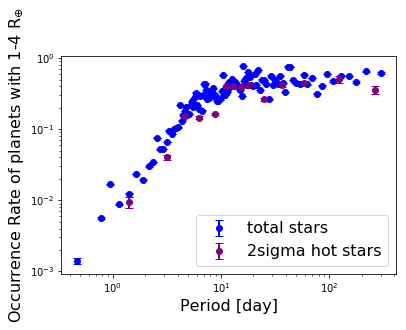

In [4]:
#等数量bin和等间隔bin差距这么大?哪一个才是真实的呢

stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_stellar_q17_add_dispersions_reduction_reduction_2020.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_koi_q17_add_dispersions_reduction_reduction_new.csv',sep=',')
#bins_period=np.logspace(math.log(0.4,10),math.log(400,10),25,base=10)

period=[]
for j in range(0,len(koi_table)):
    if koi_table['koi_disposition'][j]!='FALSE POSITIVE' \
    and koi_table['koi_prad'][j]<=4 and koi_table['koi_prad'][j]>=1 and koi_table['koi_period'][j]<=365:
        period.append(koi_table['koi_period'][j])
        
number=104
interval=20
bins_period=[]
period.sort()
print(max(period),min(period))
print(period[0:10])
for i in range(0,int(number)):
    bins_period.append(period[int(i*interval)])

bins_period.append(max(period))
print(bins_period)

bins_radius=np.logspace(-1.5,5.5,15,base=2)  


bins_t=np.logspace(math.log(120,5),math.log(6000,5),30,base=5)

focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/result/occurrence_rate_total.csv')
f_occurrence_everyplanet=focc['occurrence_rate']

bins_a_ratio=np.logspace(math.log(0.8,10),math.log(600,10),15,base=10)
number=50


a_koi_ratio=[] #use a/R_star dimensionless variance to show the correlation
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi_ratio.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value*c.au.value/(koi_table['rad_b2018'][i]*c.R_sun.value))    


f_p1=[]
f_p_std=[]
p1=[]
p_std=[]
a_ratio=[]
a_ratio_std=[]
#and koi_table['koi_disposition'][j]!='FALSE POSITIVE' \
for i in range(0,len(bins_period)-1):
    focc_temp=[]
    a_ratio_temp=[]
    p_temp=[]
    for j in range(0,len(f_occurrence_everyplanet)):
        if koi_table['koi_period'][j]<bins_period[i+1] and koi_table['koi_period'][j]>=bins_period[i] and koi_table['koi_disposition'][j]!='FALSE POSITIVE' \
        and koi_table['koi_prad'][j]<=4 and koi_table['koi_prad'][j]>=1 and koi_table['koi_period'][j]<=365:
            focc_temp.append(f_occurrence_everyplanet[j])
#            a_ratio_temp.append(a_koi_ratio[j])
            p_temp.append(koi_table['koi_period'][j])
            
    f_p1.append(np.sum(focc_temp)/np.log10(bins_period[i+1]/bins_period[i]))   
    f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
    p1.append((bins_period[i+1]+bins_period[i])/2)
    p_std.append(np.std(p_temp))
#    a_ratio.append((bins_a_ratio[i+1]+bins_a_ratio[i])/2)
#    a_ratio_std.append(np.std(a_ratio_temp))


plt.errorbar(p1,f_p1,yerr=f_p_std,fmt="o",color='blue',elinewidth=2,capsize=4,label='total stars') 


stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_stellar_q17_add_dispersions_reduction_reduction_hot_2020.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_koi_q17_add_dispersions_reduction_reduction_2sigma_hot.csv',sep=',')
#bins_period=np.logspace(math.log(0.4,10),math.log(400,10),25,base=10)

period=[]
for j in range(0,len(koi_table)):
    if koi_table['koi_disposition'][j]!='FALSE POSITIVE' \
    and koi_table['koi_prad'][j]<=4 and koi_table['koi_prad'][j]>=1 and koi_table['koi_period'][j]<=365:
        period.append(koi_table['koi_period'][j])
        
#print(period,len(period))

number=14
interval=10
bins_period=[]
period.sort()
print(max(period),min(period),len(period))
print(period[0:10])
for i in range(0,int(number)):
    bins_period.append(period[int(i*interval)])

bins_period.append(max(period))
print(bins_period)


bins_radius=np.logspace(-1.5,5.5,15,base=2)  
bins_t=np.logspace(math.log(120,5),math.log(6000,5),30,base=5)
focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/result/occurrence_rate_hot_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']
bins_a_ratio=np.logspace(math.log(0.8,10),math.log(600,10),15,base=10)
a_koi_ratio=[] #use a/R_star dimensionless variance to show the correlation
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi_ratio.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value*c.au.value/(koi_table['rad_b2018'][i]*c.R_sun.value))    

f_p2=[]
f_p_std=[]
p2=[]
p_std=[]
a_ratio=[]
a_ratio_std=[]
# and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' \
for i in range(0,len(bins_period)-1):
    focc_temp=[]
    a_ratio_temp=[]
    p_temp=[]
    
    for j in range(0,len(f_occurrence_everyplanet)):
        if koi_table['koi_period'][f_id[j]]<bins_period[i+1] and koi_table['koi_period'][f_id[j]]>=bins_period[i] and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' \
        and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1 and koi_table['koi_period'][f_id[j]]<=365:
            focc_temp.append(f_occurrence_everyplanet[j])
#            a_ratio_temp.append(a_koi_ratio[f_id[j]])
            p_temp.append(koi_table['koi_period'][f_id[j]])
            
    f_p2.append(np.sum(focc_temp)/np.log10(bins_period[i+1]/bins_period[i]))
    f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
    p2.append((bins_period[i+1]+bins_period[i])/2)
    p_std.append(np.std(p_temp))
#    a_ratio.append((bins_a_ratio[i+1]+bins_a_ratio[i])/2)
#    a_ratio_std.append(np.std(a_ratio_temp))
    
plt.errorbar(p2,f_p2,yerr=f_p_std,fmt="o",color='purple',elinewidth=2,capsize=4,label='2sigma hot stars') 


plt.xscale('log')
plt.yscale('log')
plt.xlabel('Period [day]', fontsize=16)
plt.ylabel('Occurrence Rate of planets with 1-4 R$_{\oplus}$',fontsize=16,)
plt.legend(loc='best',fontsize=16)
plt.savefig('result/p_2sigma_total_1_4Rearth_p_365_quantity.eps') #等数量取bin

#s1=stats.ks_2samp(f_p1,f_p2)

#fig=plt.figure()
#plt.plot(koi_table['koi_period'],koi_table['koi_prad'],'.')
#plt.xscale('log')
#plt.yscale('log')


In [69]:
print(len(p1))

104


[ 1.73157943 -2.0199315 ] [[ 0.0041549  -0.00264864]
 [-0.00264864  0.00207643]]
[ 0.09783821 -0.47836632] [[ 0.00142159 -0.00210995]
 [-0.00210995  0.00332182]]
[ 1.67159701 -2.19740129] [[ 0.09732113 -0.05975388]
 [-0.05975388  0.0440341 ]]
[ 0.02389581 -0.43862097] [[ 0.00383048 -0.00589911]
 [-0.00589911  0.00984341]]


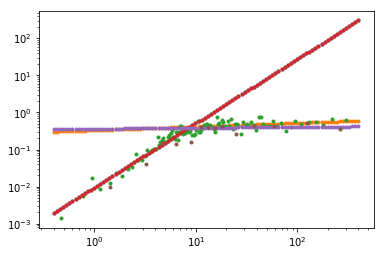

In [84]:
#python 数据拟合

#这里定义focc与period的函数关系是broken powerlaw

#def focc(x,x0,a,b,c):
#    if x<x0:
#        f=c*(x/x0)**a
#    elif x>=x0:
#        f=c*(x/x0)**b
        
#    return f

def focc(x,a,b):
    return a*x+b

x=np.log10(p1[0:50])
y=np.log10(f_p1[0:50])
popt, pcov = curve_fit(focc, x, y)
a1=popt[0]
b1=popt[1]
print(popt,pcov)

x=np.log10(p1[50:])
y=np.log10(f_p1[50:])
popt, pcov = curve_fit(focc, x, y)
a2=popt[0]
b2=popt[1]
print(popt,pcov)

xx=np.logspace(np.log10(0.4),np.log10(400),100,10)
yy1=10**b1*xx**a1
plt.plot(xx,yy,'.')
xx=np.logspace(np.log10(0.4),np.log10(400),100,10)
yy2=10**b2*xx**a2
plt.plot(xx,yy2,'.')
plt.plot(p1,f_p1,'.')
plt.xscale('log')
plt.yscale('log')

def focc(x,a,b):
    return a*x+b

x=np.log10(p2[0:5])
y=np.log10(f_p2[0:5])
popt, pcov = curve_fit(focc, x, y)
a1=popt[0]
b1=popt[1]
print(popt,pcov)

x=np.log10(p2[5:])
y=np.log10(f_p2[5:])
popt, pcov = curve_fit(focc, x, y)
a2=popt[0]
b2=popt[1]
print(popt,pcov)

xx=np.logspace(np.log10(0.4),np.log10(400),100,10)
yy1=10**b1*xx**a1
plt.plot(xx,yy,'.')
xx=np.logspace(np.log10(0.4),np.log10(400),100,10)
yy2=10**b2*xx**a2
plt.plot(xx,yy2,'.')
plt.plot(p2,f_p2,'.')
plt.xscale('log')
plt.yscale('log')

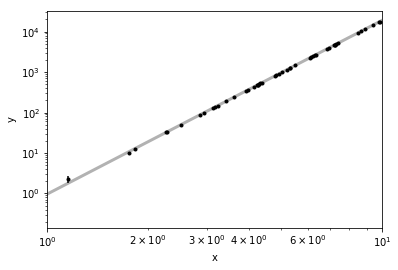

In [63]:
#python 数据拟合 emcee

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123)

# Choose the "true" parameters.
m_true = 0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = m_true*x**(b_true)
#y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(1, 10, 500)
plt.plot(x0, m_true*x0**b_true, "k", alpha=0.3, lw=3)
plt.xlim(1, 10)
plt.xlabel("x")
plt.ylabel("y")
plt.xscale("log")
plt.yscale("log")

In [64]:
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x** b
    sigma2 = yerr ** 2 + model ** 2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

Maximum likelihood estimates:
m = 0.959
b = 4.294
f = 0.000


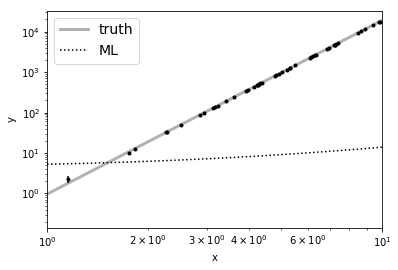

In [65]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0**b_true, "k", alpha=0.3, lw=3, label="truth")
#plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
plt.legend(fontsize=14)
plt.xlim(1, 10)
plt.xlabel("x")
plt.ylabel("y")
plt.xscale("log")
plt.yscale("log")

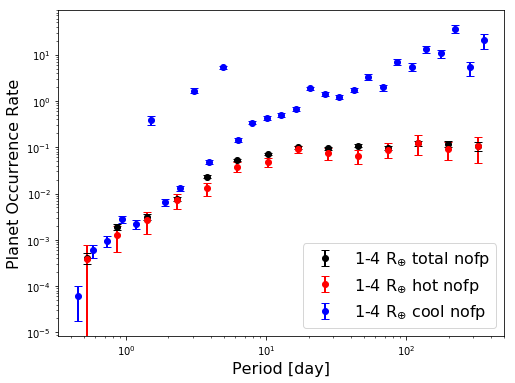

In [4]:
stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_stellar_q17_add_dispersions_reduction_reduction_2020.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_koi_q17_add_dispersions_reduction_reduction_new.csv',sep=',')
bins_period=np.logspace(math.log(0.4,10),math.log(400,10),15,base=10)
'''  
period=[]
for j in range(0,len(koi_table)):
    if koi_table['koi_disposition'][j]!='FALSE POSITIVE' \
    and koi_table['koi_prad'][j]<=4 and koi_table['koi_prad'][j]>=1 and koi_table['koi_period'][j]<=365:
        period.append(koi_table['koi_period'][j])
     
number=21
interval=100
bins_period=[]
period.sort()
print(max(period),min(period))
print(period[0:10])
for i in range(0,int(number)):
    bins_period.append(period[int(i*interval)])

bins_period.append(max(period))
print(bins_period)
'''
bins_radius=np.logspace(-1.5,5.5,15,base=2)  

fig=plt.figure(figsize=(8,6))
bins_t=np.logspace(math.log(120,5),math.log(6000,5),30,base=5)

focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/result/occurrence_rate_total.csv')
f_occurrence_everyplanet=focc['occurrence_rate']

bins_a_ratio=np.logspace(math.log(0.8,10),math.log(600,10),15,base=10)
number=50


a_koi_ratio=[] #use a/R_star dimensionless variance to show the correlation
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi_ratio.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value*c.au.value/(koi_table['rad_b2018'][i]*c.R_sun.value))    


f_p1=[]
f_p_std=[]
p=[]
p_std=[]
a_ratio=[]
a_ratio_std=[]
#and koi_table['koi_disposition'][j]!='FALSE POSITIVE' \
for i in range(0,len(bins_period)-1):
    focc_temp=[]
    a_ratio_temp=[]
    p_temp=[]
    for j in range(0,len(f_occurrence_everyplanet)):
        if koi_table['koi_period'][j]<bins_period[i+1] and koi_table['koi_period'][j]>=bins_period[i] and koi_table['koi_disposition'][j]!='FALSE POSITIVE' \
        and koi_table['koi_prad'][j]<=4 and koi_table['koi_prad'][j]>=1 and koi_table['koi_period'][j]<=365:
            focc_temp.append(f_occurrence_everyplanet[j])
#            a_ratio_temp.append(a_koi_ratio[j])
            p_temp.append(koi_table['koi_period'][j])
            
    f_p1.append(np.sum(focc_temp))
    f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
    p.append((bins_period[i+1]+bins_period[i])/2)
    p_std.append(np.std(p_temp))
#    a_ratio.append((bins_a_ratio[i+1]+bins_a_ratio[i])/2)
#    a_ratio_std.append(np.std(a_ratio_temp))


plt.errorbar(p,f_p1,yerr=f_p_std,fmt="o",color='black',elinewidth=2,capsize=4,label='1-4 R$_{\oplus}$ total nofp') 
#########################################################################################################

stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_stellar_q17_add_dispersions_reduction_reduction_hot_2020.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_koi_q17_add_dispersions_reduction_reduction_2sigma_hot.csv',sep=',')
bins_period=np.logspace(math.log(0.4,10),math.log(400,10),15,base=10)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  
bins_t=np.logspace(math.log(120,5),math.log(6000,5),30,base=5)
focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/result/occurrence_rate_hot_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']
bins_a_ratio=np.logspace(math.log(0.8,10),math.log(600,10),15,base=10)
a_koi_ratio=[] #use a/R_star dimensionless variance to show the correlation
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi_ratio.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value*c.au.value/(koi_table['rad_b2018'][i]*c.R_sun.value))    

f_p2=[]
f_p_std=[]
p=[]
p_std=[]
a_ratio=[]
a_ratio_std=[]
# and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' \
for i in range(0,len(bins_period)-1):
    focc_temp=[]
    a_ratio_temp=[]
    p_temp=[]
    
    for j in range(0,len(f_occurrence_everyplanet)):
        if koi_table['koi_period'][f_id[j]]<bins_period[i+1] and koi_table['koi_period'][f_id[j]]>=bins_period[i] and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' \
        and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1 and koi_table['koi_period'][f_id[j]]<=365:
            focc_temp.append(f_occurrence_everyplanet[j])
#            a_ratio_temp.append(a_koi_ratio[f_id[j]])
            p_temp.append(koi_table['koi_period'][f_id[j]])
            
    f_p2.append(np.sum(focc_temp))
    f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
    p.append((bins_period[i+1]+bins_period[i])/2)
    p_std.append(np.std(p_temp))
#    a_ratio.append((bins_a_ratio[i+1]+bins_a_ratio[i])/2)
#    a_ratio_std.append(np.std(a_ratio_temp))
    
plt.errorbar(p,f_p2,yerr=f_p_std,fmt="o",color='red',elinewidth=2,capsize=4,label='1-4 R$_{\oplus}$ hot nofp') 
########################################################################################3
stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_stellar_q17_add_dispersions_reduction_reduction_cool_2020.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_koi_q17_add_dispersions_reduction_reduction_2sigma_cool.csv',sep=',')
bins_period=np.logspace(math.log(0.4,10),math.log(400,10),30,base=10)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  
bins_t=np.logspace(math.log(120,5),math.log(6000,5),30,base=5)
focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/result/occurrence_rate_cool_2020_2sigma.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']
bins_a_ratio=np.logspace(math.log(0.8,10),math.log(600,10),15,base=10)
a_koi_ratio=[] #use a/R_star dimensionless variance to show the correlation
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi_ratio.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value*c.au.value/(koi_table['rad_b2018'][i]*c.R_sun.value))    

f_p2=[]
f_p_std=[]
p=[]
p_std=[]
a_ratio=[]
a_ratio_std=[]
# and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' \
for i in range(0,len(bins_period)-1):
    focc_temp=[]
    a_ratio_temp=[]
    p_temp=[]
    
    for j in range(0,len(f_occurrence_everyplanet)):
        if koi_table['koi_period'][f_id[j]]<bins_period[i+1] and koi_table['koi_period'][f_id[j]]>=bins_period[i] and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' \
        and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1 and koi_table['koi_period'][f_id[j]]<=365:
            focc_temp.append(f_occurrence_everyplanet[j])
#            a_ratio_temp.append(a_koi_ratio[f_id[j]])
            p_temp.append(koi_table['koi_period'][f_id[j]])
            
    f_p2.append(np.sum(focc_temp))
    f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
    p.append((bins_period[i+1]+bins_period[i])/2)
    p_std.append(np.std(p_temp))
#    a_ratio.append((bins_a_ratio[i+1]+bins_a_ratio[i])/2)
#    a_ratio_std.append(np.std(a_ratio_temp))
    
plt.errorbar(p,f_p2,yerr=f_p_std,fmt="o",color='blue',elinewidth=2,capsize=4,label='1-4 R$_{\oplus}$ cool nofp') 
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Period [day]', fontsize=16)
plt.ylabel('Planet Occurrence Rate',fontsize=16,)
plt.legend(loc='best',fontsize=16)
plt.savefig('result/p_2sigma_total_1_4Rearth_p_365_interval_nofp_hot_cool_tot.eps')


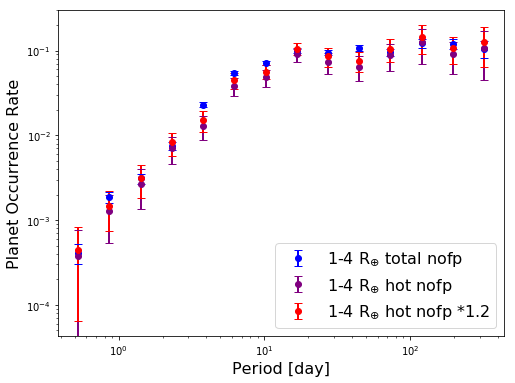

In [32]:
stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_stellar_q17_add_dispersions_reduction_reduction_2020.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_koi_q17_add_dispersions_reduction_reduction_new.csv',sep=',')
bins_period=np.logspace(math.log(0.4,10),math.log(400,10),15,base=10)
'''  
period=[]
for j in range(0,len(koi_table)):
    if koi_table['koi_disposition'][j]!='FALSE POSITIVE' \
    and koi_table['koi_prad'][j]<=4 and koi_table['koi_prad'][j]>=1 and koi_table['koi_period'][j]<=365:
        period.append(koi_table['koi_period'][j])
     
number=21
interval=100
bins_period=[]
period.sort()
print(max(period),min(period))
print(period[0:10])
for i in range(0,int(number)):
    bins_period.append(period[int(i*interval)])

bins_period.append(max(period))
print(bins_period)
'''
bins_radius=np.logspace(-1.5,5.5,15,base=2)  

fig=plt.figure(figsize=(8,6))
bins_t=np.logspace(math.log(120,5),math.log(6000,5),30,base=5)

focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/result/occurrence_rate_total.csv')
f_occurrence_everyplanet=focc['occurrence_rate']

bins_a_ratio=np.logspace(math.log(0.8,10),math.log(600,10),15,base=10)
number=50


a_koi_ratio=[] #use a/R_star dimensionless variance to show the correlation
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi_ratio.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value*c.au.value/(koi_table['rad_b2018'][i]*c.R_sun.value))    


f_p1=[]
f_p_std=[]
p=[]
p_std=[]
a_ratio=[]
a_ratio_std=[]
#and koi_table['koi_disposition'][j]!='FALSE POSITIVE' \
for i in range(0,len(bins_period)-1):
    focc_temp=[]
    a_ratio_temp=[]
    p_temp=[]
    for j in range(0,len(f_occurrence_everyplanet)):
        if koi_table['koi_period'][j]<bins_period[i+1] and koi_table['koi_period'][j]>=bins_period[i] and koi_table['koi_disposition'][j]!='FALSE POSITIVE' \
        and koi_table['koi_prad'][j]<=4 and koi_table['koi_prad'][j]>=1 and koi_table['koi_period'][j]<=365:
            focc_temp.append(f_occurrence_everyplanet[j])
#            a_ratio_temp.append(a_koi_ratio[j])
            p_temp.append(koi_table['koi_period'][j])
            
    f_p1.append(np.sum(focc_temp))
    f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
    p.append((bins_period[i+1]+bins_period[i])/2)
    p_std.append(np.std(p_temp))
#    a_ratio.append((bins_a_ratio[i+1]+bins_a_ratio[i])/2)
#    a_ratio_std.append(np.std(a_ratio_temp))


plt.errorbar(p,f_p1,yerr=f_p_std,fmt="o",color='blue',elinewidth=2,capsize=4,label='1-4 R$_{\oplus}$ total nofp') 


stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_stellar_q17_add_dispersions_reduction_reduction_hot_2020.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_koi_q17_add_dispersions_reduction_reduction_2sigma_hot.csv',sep=',')
bins_period=np.logspace(math.log(0.4,10),math.log(400,10),15,base=10)
'''
period=[]
for j in range(0,len(koi_table)):
    if koi_table['koi_disposition'][j]!='FALSE POSITIVE' \
    and koi_table['koi_prad'][j]<=4 and koi_table['koi_prad'][j]>=1 and koi_table['koi_period'][j]<=365:
        period.append(koi_table['koi_period'][j])
        
#print(period,len(period))

number=14
interval=10
bins_period=[]
period.sort()
print(max(period),min(period),len(period))
print(period[0:10])
for i in range(0,int(number)):
    bins_period.append(period[int(i*interval)])

bins_period.append(max(period))
print(bins_period)
'''

bins_radius=np.logspace(-1.5,5.5,15,base=2)  
bins_t=np.logspace(math.log(120,5),math.log(6000,5),30,base=5)
focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/result/occurrence_rate_hot_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']
bins_a_ratio=np.logspace(math.log(0.8,10),math.log(600,10),15,base=10)
a_koi_ratio=[] #use a/R_star dimensionless variance to show the correlation
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi_ratio.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value*c.au.value/(koi_table['rad_b2018'][i]*c.R_sun.value))    

f_p2=[]
f_p_std=[]
p=[]
p_std=[]
a_ratio=[]
a_ratio_std=[]
# and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' \
for i in range(0,len(bins_period)-1):
    focc_temp=[]
    a_ratio_temp=[]
    p_temp=[]
    
    for j in range(0,len(f_occurrence_everyplanet)):
        if koi_table['koi_period'][f_id[j]]<bins_period[i+1] and koi_table['koi_period'][f_id[j]]>=bins_period[i] and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' \
        and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1 and koi_table['koi_period'][f_id[j]]<=365:
            focc_temp.append(f_occurrence_everyplanet[j])
#            a_ratio_temp.append(a_koi_ratio[f_id[j]])
            p_temp.append(koi_table['koi_period'][f_id[j]])
            
    f_p2.append(np.sum(focc_temp))
    f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
    p.append((bins_period[i+1]+bins_period[i])/2)
    p_std.append(np.std(p_temp))
#    a_ratio.append((bins_a_ratio[i+1]+bins_a_ratio[i])/2)
#    a_ratio_std.append(np.std(a_ratio_temp))
    
plt.errorbar(p,f_p2,yerr=f_p_std,fmt="o",color='purple',elinewidth=2,capsize=4,label='1-4 R$_{\oplus}$ hot nofp') 

stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_stellar_q17_add_dispersions_reduction_reduction_hot_2020.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_koi_q17_add_dispersions_reduction_reduction_2sigma_hot.csv',sep=',')
bins_period=np.logspace(math.log(0.4,10),math.log(400,10),15,base=10)
'''
period=[]
for j in range(0,len(koi_table)):
    if koi_table['koi_disposition'][j]!='FALSE POSITIVE' \
    and koi_table['koi_prad'][j]<=4 and koi_table['koi_prad'][j]>=1 and koi_table['koi_period'][j]<=365:
        period.append(koi_table['koi_period'][j])
        
#print(period,len(period))

number=14
interval=10
bins_period=[]
period.sort()
print(max(period),min(period),len(period))
print(period[0:10])
for i in range(0,int(number)):
    bins_period.append(period[int(i*interval)])

bins_period.append(max(period))
print(bins_period)
'''

bins_radius=np.logspace(-1.5,5.5,15,base=2)  
bins_t=np.logspace(math.log(120,5),math.log(6000,5),30,base=5)
focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/result/occurrence_rate_hot_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']
bins_a_ratio=np.logspace(math.log(0.8,10),math.log(600,10),15,base=10)
a_koi_ratio=[] #use a/R_star dimensionless variance to show the correlation
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi_ratio.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value*c.au.value/(koi_table['rad_b2018'][i]*c.R_sun.value))    

f_p2=[]
f_p_std=[]
p=[]
p_std=[]
a_ratio=[]
a_ratio_std=[]
# and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' \
for i in range(0,len(bins_period)-1):
    focc_temp=[]
    a_ratio_temp=[]
    p_temp=[]
    
    for j in range(0,len(f_occurrence_everyplanet)):
        if koi_table['koi_period'][f_id[j]]<bins_period[i+1] and koi_table['koi_period'][f_id[j]]>=bins_period[i] and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' \
        and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1 and koi_table['koi_period'][f_id[j]]<=365:
            focc_temp.append(f_occurrence_everyplanet[j])
#            a_ratio_temp.append(a_koi_ratio[f_id[j]])
            p_temp.append(koi_table['koi_period'][f_id[j]])
            
    f_p2.append(np.sum(focc_temp)*1.17)
    f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
    p.append((bins_period[i+1]+bins_period[i])/2)
    p_std.append(np.std(p_temp))
#    a_ratio.append((bins_a_ratio[i+1]+bins_a_ratio[i])/2)
#    a_ratio_std.append(np.std(a_ratio_temp))
    
plt.errorbar(p,f_p2,yerr=f_p_std,fmt="o",color='red',elinewidth=2,capsize=4,label='1-4 R$_{\oplus}$ hot nofp *1.2') 


plt.xscale('log')
plt.yscale('log')
plt.xlabel('Period [day]', fontsize=16)
plt.ylabel('Planet Occurrence Rate',fontsize=16,)
plt.legend(loc='best',fontsize=16)
plt.savefig('result/p_2sigma_total_1_4Rearth_p_365_interval_nofp_compare.eps')



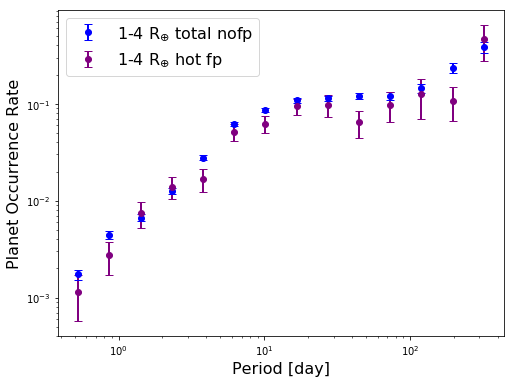

In [25]:
stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_stellar_q17_add_dispersions_reduction_reduction_2020.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_koi_q17_add_dispersions_reduction_reduction_new.csv',sep=',')
bins_period=np.logspace(math.log(0.4,10),math.log(400,10),15,base=10)
'''  
period=[]
for j in range(0,len(koi_table)):
    if koi_table['koi_disposition'][j]!='FALSE POSITIVE' \
    and koi_table['koi_prad'][j]<=4 and koi_table['koi_prad'][j]>=1 and koi_table['koi_period'][j]<=365:
        period.append(koi_table['koi_period'][j])
     
number=21
interval=100
bins_period=[]
period.sort()
print(max(period),min(period))
print(period[0:10])
for i in range(0,int(number)):
    bins_period.append(period[int(i*interval)])

bins_period.append(max(period))
print(bins_period)
'''
bins_radius=np.logspace(-1.5,5.5,15,base=2)  

fig=plt.figure(figsize=(8,6))
bins_t=np.logspace(math.log(120,5),math.log(6000,5),30,base=5)

focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/result/occurrence_rate_total.csv')
f_occurrence_everyplanet=focc['occurrence_rate']

bins_a_ratio=np.logspace(math.log(0.8,10),math.log(600,10),15,base=10)
number=50


a_koi_ratio=[] #use a/R_star dimensionless variance to show the correlation
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi_ratio.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value*c.au.value/(koi_table['rad_b2018'][i]*c.R_sun.value))    


f_p1=[]
f_p_std=[]
p=[]
p_std=[]
a_ratio=[]
a_ratio_std=[]
#and koi_table['koi_disposition'][j]!='FALSE POSITIVE' \
for i in range(0,len(bins_period)-1):
    focc_temp=[]
    a_ratio_temp=[]
    p_temp=[]
    for j in range(0,len(f_occurrence_everyplanet)):
        if koi_table['koi_period'][j]<bins_period[i+1] and koi_table['koi_period'][j]>=bins_period[i] \
        and koi_table['koi_prad'][j]<=4 and koi_table['koi_prad'][j]>=1 and koi_table['koi_period'][j]<=365:
            focc_temp.append(f_occurrence_everyplanet[j])
#            a_ratio_temp.append(a_koi_ratio[j])
            p_temp.append(koi_table['koi_period'][j])
            
    f_p1.append(np.sum(focc_temp))
    f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
    p.append((bins_period[i+1]+bins_period[i])/2)
    p_std.append(np.std(p_temp))
#    a_ratio.append((bins_a_ratio[i+1]+bins_a_ratio[i])/2)
#    a_ratio_std.append(np.std(a_ratio_temp))


plt.errorbar(p,f_p1,yerr=f_p_std,fmt="o",color='blue',elinewidth=2,capsize=4,label='1-4 R$_{\oplus}$ total nofp') 


stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_stellar_q17_add_dispersions_reduction_reduction_hot_2020.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_koi_q17_add_dispersions_reduction_reduction_2sigma_hot.csv',sep=',')
bins_period=np.logspace(math.log(0.4,10),math.log(400,10),15,base=10)
'''
period=[]
for j in range(0,len(koi_table)):
    if koi_table['koi_disposition'][j]!='FALSE POSITIVE' \
    and koi_table['koi_prad'][j]<=4 and koi_table['koi_prad'][j]>=1 and koi_table['koi_period'][j]<=365:
        period.append(koi_table['koi_period'][j])
        
#print(period,len(period))

number=14
interval=10
bins_period=[]
period.sort()
print(max(period),min(period),len(period))
print(period[0:10])
for i in range(0,int(number)):
    bins_period.append(period[int(i*interval)])

bins_period.append(max(period))
print(bins_period)
'''

bins_radius=np.logspace(-1.5,5.5,15,base=2)  
bins_t=np.logspace(math.log(120,5),math.log(6000,5),30,base=5)
focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/result/occurrence_rate_hot_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']
bins_a_ratio=np.logspace(math.log(0.8,10),math.log(600,10),15,base=10)
a_koi_ratio=[] #use a/R_star dimensionless variance to show the correlation
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi_ratio.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value*c.au.value/(koi_table['rad_b2018'][i]*c.R_sun.value))    

f_p2=[]
f_p_std=[]
p=[]
p_std=[]
a_ratio=[]
a_ratio_std=[]
# and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' \
for i in range(0,len(bins_period)-1):
    focc_temp=[]
    a_ratio_temp=[]
    p_temp=[]
    
    for j in range(0,len(f_occurrence_everyplanet)):
        if koi_table['koi_period'][f_id[j]]<bins_period[i+1] and koi_table['koi_period'][f_id[j]]>=bins_period[i] \
        and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1 and koi_table['koi_period'][f_id[j]]<=365:
            focc_temp.append(f_occurrence_everyplanet[j])
#            a_ratio_temp.append(a_koi_ratio[f_id[j]])
            p_temp.append(koi_table['koi_period'][f_id[j]])
            
    f_p2.append(np.sum(focc_temp))
    f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
    p.append((bins_period[i+1]+bins_period[i])/2)
    p_std.append(np.std(p_temp))
#    a_ratio.append((bins_a_ratio[i+1]+bins_a_ratio[i])/2)
#    a_ratio_std.append(np.std(a_ratio_temp))
    
plt.errorbar(p,f_p2,yerr=f_p_std,fmt="o",color='purple',elinewidth=2,capsize=4,label='1-4 R$_{\oplus}$ hot fp') 


plt.xscale('log')
plt.yscale('log')
plt.xlabel('Period [day]', fontsize=16)
plt.ylabel('Planet Occurrence Rate',fontsize=16,)
plt.legend(loc='best',fontsize=16)
plt.savefig('result/p_2sigma_total_1_4Rearth_p_365_interval_fp.eps')


2712
2083
491
264



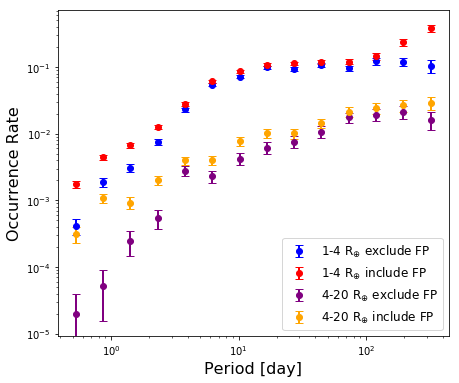

In [11]:
stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_stellar_q17_add_dispersions_reduction_reduction_2020.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_koi_q17_add_dispersions_reduction_reduction_new.csv',sep=',')
bins_period=np.logspace(math.log(0.4,10),math.log(400,10),15,base=10)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  


bins_t=np.logspace(math.log(120,5),math.log(6000,5),30,base=5)

focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/result/occurrence_rate_total.csv')
f_occurrence_everyplanet=focc['occurrence_rate']

bins_a_ratio=np.logspace(math.log(0.8,10),math.log(600,10),15,base=10)
number=50


a_koi_ratio=[] #use a/R_star dimensionless variance to show the correlation
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi_ratio.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value*c.au.value/(koi_table['rad_b2018'][i]*c.R_sun.value))    


f_p1=[]
f_p_std=[]
p=[]
p_std=[]
a_ratio=[]
a_ratio_std=[]
#and koi_table['koi_disposition'][j]!='FALSE POSITIVE' \
for i in range(0,len(bins_period)-1):
    focc_temp=[]
    a_ratio_temp=[]
    p_temp=[]
    for j in range(0,len(f_occurrence_everyplanet)):
        if koi_table['koi_period'][j]<bins_period[i+1] and koi_table['koi_period'][j]>=bins_period[i] and koi_table['koi_disposition'][j]!='FALSE POSITIVE' \
        and koi_table['koi_prad'][j]<=4 and koi_table['koi_prad'][j]>=1 and koi_table['koi_period'][j]<=365:
            focc_temp.append(f_occurrence_everyplanet[j])
#            a_ratio_temp.append(a_koi_ratio[j])
            p_temp.append(koi_table['koi_period'][j])
            
    f_p1.append(np.sum(focc_temp))
    f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
    p.append((bins_period[i+1]+bins_period[i])/2)
    p_std.append(np.std(p_temp))
#    a_ratio.append((bins_a_ratio[i+1]+bins_a_ratio[i])/2)
#    a_ratio_std.append(np.std(a_ratio_temp))

fig=plt.figure(figsize=(7,6))
plt.errorbar(p,f_p1,yerr=f_p_std,fmt="o",color='blue',elinewidth=2,capsize=4,label='1-4 R$_{\oplus}$ exclude FP') 
##############################################################################3
bins_period=np.logspace(math.log(0.4,10),math.log(400,10),15,base=10)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  


bins_t=np.logspace(math.log(120,5),math.log(6000,5),30,base=5)

focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/result/occurrence_rate_total.csv')
f_occurrence_everyplanet=focc['occurrence_rate']

bins_a_ratio=np.logspace(math.log(0.8,10),math.log(600,10),15,base=10)
number=50


a_koi_ratio=[] #use a/R_star dimensionless variance to show the correlation
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi_ratio.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value*c.au.value/(koi_table['rad_b2018'][i]*c.R_sun.value))    


f_p1=[]
f_p_std=[]
p=[]
p_std=[]
a_ratio=[]
a_ratio_std=[]
#and koi_table['koi_disposition'][j]!='FALSE POSITIVE' \
for i in range(0,len(bins_period)-1):
    focc_temp=[]
    a_ratio_temp=[]
    p_temp=[]
    for j in range(0,len(f_occurrence_everyplanet)):
        if koi_table['koi_period'][j]<bins_period[i+1] and koi_table['koi_period'][j]>=bins_period[i] \
        and koi_table['koi_prad'][j]<=4 and koi_table['koi_prad'][j]>=1 and koi_table['koi_period'][j]<=365:
            focc_temp.append(f_occurrence_everyplanet[j])
#            a_ratio_temp.append(a_koi_ratio[j])
            p_temp.append(koi_table['koi_period'][j])
            
    f_p1.append(np.sum(focc_temp))
    f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
    p.append((bins_period[i+1]+bins_period[i])/2)
    p_std.append(np.std(p_temp))
#    a_ratio.append((bins_a_ratio[i+1]+bins_a_ratio[i])/2)
#    a_ratio_std.append(np.std(a_ratio_temp))


plt.errorbar(p,f_p1,yerr=f_p_std,fmt="o",color='red',elinewidth=2,capsize=4,label='1-4 R$_{\oplus}$ include FP')
count=0
for j in range(0,len(koi_table)):
    if koi_table['koi_prad'][j]<=4 and koi_table['koi_prad'][j]>=1 and koi_table['koi_period'][j]<=365:
        count+=1
print(count)

count=0
for j in range(0,len(koi_table)):
    if koi_table['koi_prad'][j]<=4 and koi_table['koi_prad'][j]>=1 and koi_table['koi_period'][j]<=365 and koi_table['koi_disposition'][j]!='FALSE POSITIVE':
        count+=1
print(count)


#####################################################################################################
stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_stellar_q17_add_dispersions_reduction_reduction_2020.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_koi_q17_add_dispersions_reduction_reduction_new.csv',sep=',')
bins_period=np.logspace(math.log(0.4,10),math.log(400,10),15,base=10)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  


bins_t=np.logspace(math.log(120,5),math.log(6000,5),30,base=5)

focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/result/occurrence_rate_total.csv')
f_occurrence_everyplanet=focc['occurrence_rate']

bins_a_ratio=np.logspace(math.log(0.8,10),math.log(600,10),15,base=10)
number=50


a_koi_ratio=[] #use a/R_star dimensionless variance to show the correlation
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi_ratio.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value*c.au.value/(koi_table['rad_b2018'][i]*c.R_sun.value))    


f_p1=[]
f_p_std=[]
p=[]
p_std=[]
a_ratio=[]
a_ratio_std=[]
#and koi_table['koi_disposition'][j]!='FALSE POSITIVE' \
for i in range(0,len(bins_period)-1):
    focc_temp=[]
    a_ratio_temp=[]
    p_temp=[]
    for j in range(0,len(f_occurrence_everyplanet)):
        if koi_table['koi_period'][j]<bins_period[i+1] and koi_table['koi_period'][j]>=bins_period[i] and koi_table['koi_disposition'][j]!='FALSE POSITIVE' \
        and koi_table['koi_prad'][j]<=20 and koi_table['koi_prad'][j]>=4 and koi_table['koi_period'][j]<=365:
            focc_temp.append(f_occurrence_everyplanet[j])
#            a_ratio_temp.append(a_koi_ratio[j])
            p_temp.append(koi_table['koi_period'][j])
            
    f_p1.append(np.sum(focc_temp))
    f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
    p.append((bins_period[i+1]+bins_period[i])/2)
    p_std.append(np.std(p_temp))
#    a_ratio.append((bins_a_ratio[i+1]+bins_a_ratio[i])/2)
#    a_ratio_std.append(np.std(a_ratio_temp))


plt.errorbar(p,f_p1,yerr=f_p_std,fmt="o",color='purple',elinewidth=2,capsize=4,label='4-20 R$_{\oplus}$ exclude FP') 
##############################################################################3
bins_period=np.logspace(math.log(0.4,10),math.log(400,10),15,base=10)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  


bins_t=np.logspace(math.log(120,5),math.log(6000,5),30,base=5)

focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/result/occurrence_rate_total.csv')
f_occurrence_everyplanet=focc['occurrence_rate']

bins_a_ratio=np.logspace(math.log(0.8,10),math.log(600,10),15,base=10)
number=50


a_koi_ratio=[] #use a/R_star dimensionless variance to show the correlation
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi_ratio.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value*c.au.value/(koi_table['rad_b2018'][i]*c.R_sun.value))    


f_p1=[]
f_p_std=[]
p=[]
p_std=[]
a_ratio=[]
a_ratio_std=[]
#and koi_table['koi_disposition'][j]!='FALSE POSITIVE' \
for i in range(0,len(bins_period)-1):
    focc_temp=[]
    a_ratio_temp=[]
    p_temp=[]
    for j in range(0,len(f_occurrence_everyplanet)):
        if koi_table['koi_period'][j]<bins_period[i+1] and koi_table['koi_period'][j]>=bins_period[i] \
        and koi_table['koi_prad'][j]<=20 and koi_table['koi_prad'][j]>=4 and koi_table['koi_period'][j]<=365:
            focc_temp.append(f_occurrence_everyplanet[j])
#            a_ratio_temp.append(a_koi_ratio[j])
            p_temp.append(koi_table['koi_period'][j])
            
    f_p1.append(np.sum(focc_temp))
    f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
    p.append((bins_period[i+1]+bins_period[i])/2)
    p_std.append(np.std(p_temp))
#    a_ratio.append((bins_a_ratio[i+1]+bins_a_ratio[i])/2)
#    a_ratio_std.append(np.std(a_ratio_temp))


plt.errorbar(p,f_p1,yerr=f_p_std,fmt="o",color='orange',elinewidth=2,capsize=4,label='4-20 R$_{\oplus}$ include FP')
count=0
for j in range(0,len(koi_table)):
    if koi_table['koi_prad'][j]<=20 and koi_table['koi_prad'][j]>=4 and koi_table['koi_period'][j]<=365:
        count+=1
print(count)

count=0
for j in range(0,len(koi_table)):
    if koi_table['koi_prad'][j]<=20 and koi_table['koi_prad'][j]>=4 and koi_table['koi_period'][j]<=365 and koi_table['koi_disposition'][j]!='FALSE POSITIVE':
        count+=1
print(count)

'''
stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_stellar_q17_add_dispersions_reduction_reduction_hot_2020.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_koi_q17_add_dispersions_reduction_reduction_2sigma_hot.csv',sep=',')
bins_period=np.logspace(math.log(0.4,10),math.log(400,10),15,base=10)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  
bins_t=np.logspace(math.log(120,5),math.log(6000,5),30,base=5)
focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/result/occurrence_rate_hot_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']
bins_a_ratio=np.logspace(math.log(0.8,10),math.log(600,10),15,base=10)
a_koi_ratio=[] #use a/R_star dimensionless variance to show the correlation
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi_ratio.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value*c.au.value/(koi_table['rad_b2018'][i]*c.R_sun.value))    

f_p2=[]
f_p_std=[]
p=[]
p_std=[]
a_ratio=[]
a_ratio_std=[]
# and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' \
for i in range(0,len(bins_period)-1):
    focc_temp=[]
    a_ratio_temp=[]
    p_temp=[]
    
    for j in range(0,len(f_occurrence_everyplanet)):
        if koi_table['koi_period'][f_id[j]]<bins_period[i+1] and koi_table['koi_period'][f_id[j]]>=bins_period[i] and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' \
        and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1 and koi_table['koi_period'][f_id[j]]<=365:
            focc_temp.append(f_occurrence_everyplanet[j])
#            a_ratio_temp.append(a_koi_ratio[f_id[j]])
            p_temp.append(koi_table['koi_period'][f_id[j]])
            
    f_p2.append(np.sum(focc_temp))
    f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
    p.append((bins_period[i+1]+bins_period[i])/2)
    p_std.append(np.std(p_temp))
#    a_ratio.append((bins_a_ratio[i+1]+bins_a_ratio[i])/2)
#    a_ratio_std.append(np.std(a_ratio_temp))
    
plt.errorbar(p,f_p2,yerr=f_p_std,fmt="o",color='purple',elinewidth=2,capsize=4,label='hot stars nofp') 
##############################################################################################################
stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_stellar_q17_add_dispersions_reduction_reduction_hot_2020.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_koi_q17_add_dispersions_reduction_reduction_2sigma_hot.csv',sep=',')
bins_period=np.logspace(math.log(0.4,10),math.log(400,10),15,base=10)

bins_radius=np.logspace(-1.5,5.5,15,base=2)  
bins_t=np.logspace(math.log(120,5),math.log(6000,5),30,base=5)
focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/result/occurrence_rate_hot_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']
bins_a_ratio=np.logspace(math.log(0.8,10),math.log(600,10),15,base=10)
a_koi_ratio=[] #use a/R_star dimensionless variance to show the correlation
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi_ratio.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value*c.au.value/(koi_table['rad_b2018'][i]*c.R_sun.value))    

f_p2=[]
f_p_std=[]
p=[]
p_std=[]
a_ratio=[]
a_ratio_std=[]
# and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' \
for i in range(0,len(bins_period)-1):
    focc_temp=[]
    a_ratio_temp=[]
    p_temp=[]
    
    for j in range(0,len(f_occurrence_everyplanet)):
        if koi_table['koi_period'][f_id[j]]<bins_period[i+1] and koi_table['koi_period'][f_id[j]]>=bins_period[i] \
        and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1 and koi_table['koi_period'][f_id[j]]<=365:
            focc_temp.append(f_occurrence_everyplanet[j])
#            a_ratio_temp.append(a_koi_ratio[f_id[j]])
            p_temp.append(koi_table['koi_period'][f_id[j]])
            
    f_p2.append(np.sum(focc_temp))
    f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
    p.append((bins_period[i+1]+bins_period[i])/2)
    p_std.append(np.std(p_temp))
#    a_ratio.append((bins_a_ratio[i+1]+bins_a_ratio[i])/2)
#    a_ratio_std.append(np.std(a_ratio_temp))
    
plt.errorbar(p,f_p2,yerr=f_p_std,fmt="o",color='orange',elinewidth=2,capsize=4,label='hot stars fp')
'''
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Period [day]', fontsize=16)
plt.ylabel('Occurrence Rate',fontsize=16)
plt.legend(loc='best',fontsize=12)
plt.savefig('result/p_total_1_20Rearth_p_365_fp_vs_nofp.eps')
print()

/home/dyz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:181: RuntimeWarning: invalid value encountered in double_scalars


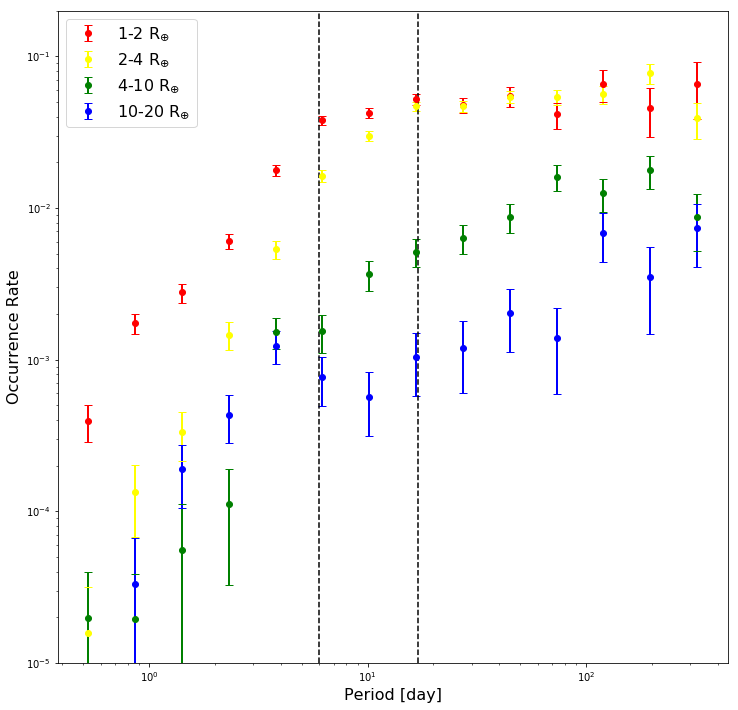

In [13]:
stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_stellar_q17_add_dispersions_reduction_reduction_2020.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_koi_q17_add_dispersions_reduction_reduction_new.csv',sep=',')
bins_period=np.logspace(math.log(0.4,10),math.log(400,10),15,base=10)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  
bins_t=np.logspace(math.log(120,5),math.log(6000,5),30,base=5)

focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/result/occurrence_rate_total.csv')
f_occurrence_everyplanet=focc['occurrence_rate']

bins_a_ratio=np.logspace(math.log(0.8,10),math.log(600,10),15,base=10)
number=50


a_koi_ratio=[] #use a/R_star dimensionless variance to show the correlation
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi_ratio.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value*c.au.value/(koi_table['rad_b2018'][i]*c.R_sun.value))    


f_p1=[]
f_p_std=[]
p=[]
p_std=[]
a_ratio=[]
a_ratio_std=[]
#and koi_table['koi_disposition'][j]!='FALSE POSITIVE' \
for i in range(0,len(bins_period)-1):
    focc_temp=[]
    a_ratio_temp=[]
    p_temp=[]
    for j in range(0,len(f_occurrence_everyplanet)):
        if koi_table['koi_period'][j]<bins_period[i+1] and koi_table['koi_period'][j]>=bins_period[i] and koi_table['koi_disposition'][j]!='FALSE POSITIVE' \
        and koi_table['koi_prad'][j]<=2 and koi_table['koi_prad'][j]>=1 and koi_table['koi_period'][j]<=365:
            focc_temp.append(f_occurrence_everyplanet[j])
#            a_ratio_temp.append(a_koi_ratio[j])
            p_temp.append(koi_table['koi_period'][j])
            
    f_p1.append(np.sum(focc_temp))
    f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
    p.append((bins_period[i+1]+bins_period[i])/2)
    p_std.append(np.std(p_temp))
#    a_ratio.append((bins_a_ratio[i+1]+bins_a_ratio[i])/2)
#    a_ratio_std.append(np.std(a_ratio_temp))

fig=plt.figure(figsize=(12,12))
plt.errorbar(p,f_p1,yerr=f_p_std,fmt="o",color='red',elinewidth=2,capsize=4,label='1-2 R$_{\oplus}$') 
#######################################################################################################
stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_stellar_q17_add_dispersions_reduction_reduction_2020.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_koi_q17_add_dispersions_reduction_reduction_new.csv',sep=',')
bins_period=np.logspace(math.log(0.4,10),math.log(400,10),15,base=10)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  


bins_t=np.logspace(math.log(120,5),math.log(6000,5),30,base=5)

focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/result/occurrence_rate_total.csv')
f_occurrence_everyplanet=focc['occurrence_rate']

bins_a_ratio=np.logspace(math.log(0.8,10),math.log(600,10),15,base=10)
number=50


a_koi_ratio=[] #use a/R_star dimensionless variance to show the correlation
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi_ratio.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value*c.au.value/(koi_table['rad_b2018'][i]*c.R_sun.value))    


f_p1=[]
f_p_std=[]
p=[]
p_std=[]
a_ratio=[]
a_ratio_std=[]
#and koi_table['koi_disposition'][j]!='FALSE POSITIVE' \
for i in range(0,len(bins_period)-1):
    focc_temp=[]
    a_ratio_temp=[]
    p_temp=[]
    for j in range(0,len(f_occurrence_everyplanet)):
        if koi_table['koi_period'][j]<bins_period[i+1] and koi_table['koi_period'][j]>=bins_period[i] and koi_table['koi_disposition'][j]!='FALSE POSITIVE' \
        and koi_table['koi_prad'][j]<=4 and koi_table['koi_prad'][j]>=2 and koi_table['koi_period'][j]<=365:
            focc_temp.append(f_occurrence_everyplanet[j])
#            a_ratio_temp.append(a_koi_ratio[j])
            p_temp.append(koi_table['koi_period'][j])
            
    f_p1.append(np.sum(focc_temp))
    f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
    p.append((bins_period[i+1]+bins_period[i])/2)
    p_std.append(np.std(p_temp))
#    a_ratio.append((bins_a_ratio[i+1]+bins_a_ratio[i])/2)
#    a_ratio_std.append(np.std(a_ratio_temp))
plt.errorbar(p,f_p1,yerr=f_p_std,fmt="o",color='yellow',elinewidth=2,capsize=4,label='2-4 R$_{\oplus}$') 
#######################################################################################################
stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_stellar_q17_add_dispersions_reduction_reduction_2020.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_koi_q17_add_dispersions_reduction_reduction_new.csv',sep=',')
bins_period=np.logspace(math.log(0.4,10),math.log(400,10),15,base=10)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  


bins_t=np.logspace(math.log(120,5),math.log(6000,5),30,base=5)

focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/result/occurrence_rate_total.csv')
f_occurrence_everyplanet=focc['occurrence_rate']

bins_a_ratio=np.logspace(math.log(0.8,10),math.log(600,10),15,base=10)
number=50


a_koi_ratio=[] #use a/R_star dimensionless variance to show the correlation
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi_ratio.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value*c.au.value/(koi_table['rad_b2018'][i]*c.R_sun.value))    


f_p1=[]
f_p_std=[]
p=[]
p_std=[]
a_ratio=[]
a_ratio_std=[]
#and koi_table['koi_disposition'][j]!='FALSE POSITIVE' \
for i in range(0,len(bins_period)-1):
    focc_temp=[]
    a_ratio_temp=[]
    p_temp=[]
    for j in range(0,len(f_occurrence_everyplanet)):
        if koi_table['koi_period'][j]<bins_period[i+1] and koi_table['koi_period'][j]>=bins_period[i] and koi_table['koi_disposition'][j]!='FALSE POSITIVE' \
        and koi_table['koi_prad'][j]<=10 and koi_table['koi_prad'][j]>=4 and koi_table['koi_period'][j]<=365:
            focc_temp.append(f_occurrence_everyplanet[j])
#            a_ratio_temp.append(a_koi_ratio[j])
            p_temp.append(koi_table['koi_period'][j])
            
    f_p1.append(np.sum(focc_temp))
    f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
    p.append((bins_period[i+1]+bins_period[i])/2)
    p_std.append(np.std(p_temp))
#    a_ratio.append((bins_a_ratio[i+1]+bins_a_ratio[i])/2)
#    a_ratio_std.append(np.std(a_ratio_temp))
plt.errorbar(p,f_p1,yerr=f_p_std,fmt="o",color='green',elinewidth=2,capsize=4,label='4-10 R$_{\oplus}$') 

#######################################################################################################
stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_stellar_q17_add_dispersions_reduction_reduction_2020.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_koi_q17_add_dispersions_reduction_reduction_new.csv',sep=',')
bins_period=np.logspace(math.log(0.4,10),math.log(400,10),15,base=10)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  


bins_t=np.logspace(math.log(120,5),math.log(6000,5),30,base=5)

focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/result/occurrence_rate_total.csv')
f_occurrence_everyplanet=focc['occurrence_rate']

bins_a_ratio=np.logspace(math.log(0.8,10),math.log(600,10),15,base=10)
number=50


a_koi_ratio=[] #use a/R_star dimensionless variance to show the correlation
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi_ratio.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value*c.au.value/(koi_table['rad_b2018'][i]*c.R_sun.value))    


f_p1=[]
f_p_std=[]
p=[]
p_std=[]
a_ratio=[]
a_ratio_std=[]
#and koi_table['koi_disposition'][j]!='FALSE POSITIVE' \
for i in range(0,len(bins_period)-1):
    focc_temp=[]
    a_ratio_temp=[]
    p_temp=[]
    for j in range(0,len(f_occurrence_everyplanet)):
        if koi_table['koi_period'][j]<bins_period[i+1] and koi_table['koi_period'][j]>=bins_period[i] and koi_table['koi_disposition'][j]!='FALSE POSITIVE' \
        and koi_table['koi_prad'][j]<=20 and koi_table['koi_prad'][j]>=10 and koi_table['koi_period'][j]<=365:
            focc_temp.append(f_occurrence_everyplanet[j])
#            a_ratio_temp.append(a_koi_ratio[j])
            p_temp.append(koi_table['koi_period'][j])
            
    f_p1.append(np.sum(focc_temp))
    f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
    p.append((bins_period[i+1]+bins_period[i])/2)
    p_std.append(np.std(p_temp))
#    a_ratio.append((bins_a_ratio[i+1]+bins_a_ratio[i])/2)
#    a_ratio_std.append(np.std(a_ratio_temp))
plt.errorbar(p,f_p1,yerr=f_p_std,fmt="o",color='blue',elinewidth=2,capsize=4,label='10-20 R$_{\oplus}$') 
xx=[6]*1000
yy=np.linspace(1e-5,2e-1,1000)
plt.plot(xx,yy,'k--')

xx=[17]*1000
yy=np.linspace(1e-5,2e-1,1000)
plt.plot(xx,yy,'k--')

plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-5,2e-1)
plt.xlabel('Period [day]', fontsize=16)
plt.ylabel('Occurrence Rate',fontsize=16)
plt.legend(loc='best',fontsize=16)
plt.savefig('result/p_total_1_20Rearth_p_365_interval.eps')


In [5]:
print(max(koi_table['koi_prad']))

2912.48


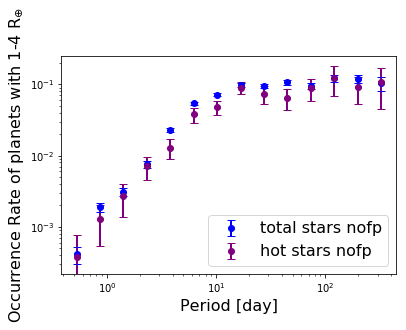

In [2]:
stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_stellar_q17_add_dispersions_reduction_reduction_2020.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_koi_q17_add_dispersions_reduction_reduction_new.csv',sep=',')
bins_period=np.logspace(math.log(0.4,10),math.log(400,10),15,base=10)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  


bins_t=np.logspace(math.log(120,5),math.log(6000,5),30,base=5)

focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/result/occurrence_rate_total.csv')
f_occurrence_everyplanet=focc['occurrence_rate']

bins_a_ratio=np.logspace(math.log(0.8,10),math.log(600,10),15,base=10)
number=50


a_koi_ratio=[] #use a/R_star dimensionless variance to show the correlation
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi_ratio.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value*c.au.value/(koi_table['rad_b2018'][i]*c.R_sun.value))    


f_p1=[]
f_p_std=[]
p=[]
p_std=[]
a_ratio=[]
a_ratio_std=[]
#and koi_table['koi_disposition'][j]!='FALSE POSITIVE' \
for i in range(0,len(bins_period)-1):
    focc_temp=[]
    a_ratio_temp=[]
    p_temp=[]
    for j in range(0,len(f_occurrence_everyplanet)):
        if koi_table['koi_period'][j]<bins_period[i+1] and koi_table['koi_period'][j]>=bins_period[i] and koi_table['koi_disposition'][j]!='FALSE POSITIVE' \
        and koi_table['koi_prad'][j]<=4 and koi_table['koi_prad'][j]>=1 and koi_table['koi_period'][j]<=365:
            focc_temp.append(f_occurrence_everyplanet[j])
#            a_ratio_temp.append(a_koi_ratio[j])
            p_temp.append(koi_table['koi_period'][j])
            
    f_p1.append(np.sum(focc_temp))
    f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
    p.append((bins_period[i+1]+bins_period[i])/2)
    p_std.append(np.std(p_temp))
#    a_ratio.append((bins_a_ratio[i+1]+bins_a_ratio[i])/2)
#    a_ratio_std.append(np.std(a_ratio_temp))


plt.errorbar(p,f_p1,yerr=f_p_std,fmt="o",color='blue',elinewidth=2,capsize=4,label='total stars nofp') 
######################################################################################
stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_stellar_q17_add_dispersions_reduction_reduction_hot_2020.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_koi_q17_add_dispersions_reduction_reduction_2sigma_hot.csv',sep=',')
bins_period=np.logspace(math.log(0.4,10),math.log(400,10),15,base=10)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  
bins_t=np.logspace(math.log(120,5),math.log(6000,5),30,base=5)
focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/result/occurrence_rate_hot_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']
bins_a_ratio=np.logspace(math.log(0.8,10),math.log(600,10),15,base=10)
a_koi_ratio=[] #use a/R_star dimensionless variance to show the correlation
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi_ratio.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value*c.au.value/(koi_table['rad_b2018'][i]*c.R_sun.value))    

f_p2=[]
f_p_std=[]
p=[]
p_std=[]
a_ratio=[]
a_ratio_std=[]
# and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' \
for i in range(0,len(bins_period)-1):
    focc_temp=[]
    a_ratio_temp=[]
    p_temp=[]
    
    for j in range(0,len(f_occurrence_everyplanet)):
        if koi_table['koi_period'][f_id[j]]<bins_period[i+1] and koi_table['koi_period'][f_id[j]]>=bins_period[i] and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' \
        and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1 and koi_table['koi_period'][f_id[j]]<=365:
            focc_temp.append(f_occurrence_everyplanet[j])
#            a_ratio_temp.append(a_koi_ratio[f_id[j]])
            p_temp.append(koi_table['koi_period'][f_id[j]])
            
    f_p2.append(np.sum(focc_temp))
    f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
    p.append((bins_period[i+1]+bins_period[i])/2)
    p_std.append(np.std(p_temp))
#    a_ratio.append((bins_a_ratio[i+1]+bins_a_ratio[i])/2)
#    a_ratio_std.append(np.std(a_ratio_temp))
    
plt.errorbar(p,f_p2,yerr=f_p_std,fmt="o",color='purple',elinewidth=2,capsize=4,label='hot stars nofp') 
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Period [day]', fontsize=16)
plt.ylabel('Occurrence Rate of planets with 1-4 R$_{\oplus}$',fontsize=16,)
plt.legend(loc='best',fontsize=16)
plt.savefig('result/p_2sigma_total_1_4Rearth_p_365_interval.eps')

9926
104016
[3.236348517770127, 2.5111523892808676, 3.0724931104756124, 1.2004553361961794, 1.5862959377073995, 3.080707006559659] 2.447908716331641
[7.294578680857711, 6.9072126651167665, 7.307704224484436, 3.1308361326697116, 4.497131394478378, 6.023532559957373] 5.860165942927396


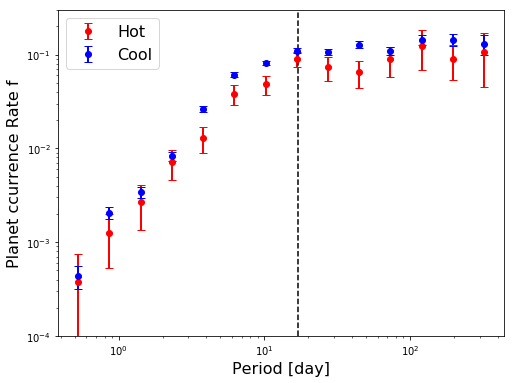

In [17]:
######################################################################################
stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_stellar_q17_add_dispersions_reduction_reduction_hot_2020.csv',sep=',')
print(len(stellar_table))
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_koi_q17_add_dispersions_reduction_reduction_2sigma_hot.csv',sep=',')
bins_period=np.logspace(math.log(0.4,10),math.log(400,10),15,base=10)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  
bins_t=np.logspace(math.log(120,5),math.log(6000,5),30,base=5)
focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/result/occurrence_rate_hot_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']
bins_a_ratio=np.logspace(math.log(0.8,10),math.log(600,10),15,base=10)
a_koi_ratio=[] #use a/R_star dimensionless variance to show the correlation
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi_ratio.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value*c.au.value/(koi_table['rad_b2018'][i]*c.R_sun.value))    

f_p1=[]
f_p_std1=[]
p=[]
p_std=[]
a_ratio=[]
a_ratio_std=[]
# and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' \
for i in range(0,len(bins_period)-1):
    focc_temp=[]
    a_ratio_temp=[]
    p_temp=[]
    
    for j in range(0,len(f_occurrence_everyplanet)):
        if koi_table['koi_period'][f_id[j]]<bins_period[i+1] and koi_table['koi_period'][f_id[j]]>=bins_period[i] and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' \
        and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1 and koi_table['koi_period'][f_id[j]]<=365:
            focc_temp.append(f_occurrence_everyplanet[j])
#            a_ratio_temp.append(a_koi_ratio[f_id[j]])
            p_temp.append(koi_table['koi_period'][f_id[j]])
            
    f_p1.append(np.sum(focc_temp))
    f_p_std1.append(np.sum(focc_temp)/len(focc_temp)**0.5)
    p.append((bins_period[i+1]+bins_period[i])/2)
    p_std.append(np.std(p_temp))
#    a_ratio.append((bins_a_ratio[i+1]+bins_a_ratio[i])/2)
#    a_ratio_std.append(np.std(a_ratio_temp))
fig=plt.figure(figsize=(8,6))    
plt.errorbar(p,f_p1,yerr=f_p_std1,fmt="o",color='red',elinewidth=2,capsize=4,label='Hot') 
######################################################################################
stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_stellar_q17_add_dispersions_reduction_reduction_cool_2020.csv',sep=',')
print(len(stellar_table))
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_koi_q17_add_dispersions_reduction_reduction_2sigma_cool.csv',sep=',')
bins_period=np.logspace(math.log(0.4,10),math.log(400,10),15,base=10)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  
bins_t=np.logspace(math.log(120,5),math.log(6000,5),30,base=5)
focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/result/occurrence_rate_cool_2020_2sigma.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']
bins_a_ratio=np.logspace(math.log(0.8,10),math.log(600,10),15,base=10)
a_koi_ratio=[] #use a/R_star dimensionless variance to show the correlation
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi_ratio.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value*c.au.value/(koi_table['rad_b2018'][i]*c.R_sun.value))    

f_p2=[]
f_p_std2=[]
p=[]
p_std=[]
a_ratio=[]
a_ratio_std=[]
# and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' \
for i in range(0,len(bins_period)-1):
    focc_temp=[]
    a_ratio_temp=[]
    p_temp=[]
    
    for j in range(0,len(f_occurrence_everyplanet)):
        if koi_table['koi_period'][f_id[j]]<bins_period[i+1] and koi_table['koi_period'][f_id[j]]>=bins_period[i] and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' \
        and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1 and koi_table['koi_period'][f_id[j]]<=365:
            focc_temp.append(f_occurrence_everyplanet[j])
#            a_ratio_temp.append(a_koi_ratio[f_id[j]])
            p_temp.append(koi_table['koi_period'][f_id[j]])
            
    f_p2.append(np.sum(focc_temp))
    f_p_std2.append(np.sum(focc_temp)/len(focc_temp)**0.5)
    p.append((bins_period[i+1]+bins_period[i])/2)
    p_std.append(np.std(p_temp))
#    a_ratio.append((bins_a_ratio[i+1]+bins_a_ratio[i])/2)
#    a_ratio_std.append(np.std(a_ratio_temp))
    
plt.errorbar(p,f_p2,yerr=f_p_std2,fmt="o",color='blue',elinewidth=2,capsize=4,label='Cool') 
xx=[17]*100
yy=np.linspace(1e-4,3e-1,100)
plt.plot(xx,yy,'k--')

#xx=[20]*100
#yy=np.linspace(1e-4,3e-1,100)
#plt.plot(xx,yy,'k--')
confidence1=[]
confidence2=[]
for i in range(4,10):
    confidence1.append(abs(f_p2[i]-f_p1[i])/f_p_std1[i])
    confidence2.append(abs(f_p1[i]-f_p2[i])/f_p_std2[i])
    
print(confidence1,np.mean(confidence1))
print(confidence2,np.mean(confidence2))

plt.ylim(1e-4,3e-1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Period [day]', fontsize=16)
plt.ylabel('Planet ccurrence Rate f',fontsize=16,)
plt.legend(loc='best',fontsize=16)
plt.savefig('result/p_2hot_2cool_1_4Rearth_p_365_interval.eps')

9926
104016
[1.1034731251239585, 0.29973305098135816, 0.5576167553172151, 0.9947513782473812, 0.09716991324098546, 0.9997121176503129] 0.6754093900935353
[3.730765470358589, 1.2366752022278198, 1.9893771142634729, 3.891527819654265, 0.4132134399206099, 2.932021032069209] 2.365596679748994


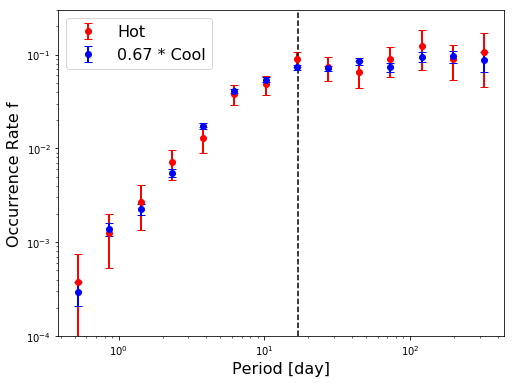

In [63]:
######################################################################################
stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_stellar_q17_add_dispersions_reduction_reduction_hot_2020.csv',sep=',')
print(len(stellar_table))
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_koi_q17_add_dispersions_reduction_reduction_2sigma_hot.csv',sep=',')
bins_period=np.logspace(math.log(0.4,10),math.log(400,10),15,base=10)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  
bins_t=np.logspace(math.log(120,5),math.log(6000,5),30,base=5)
focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/result/occurrence_rate_hot_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']
bins_a_ratio=np.logspace(math.log(0.8,10),math.log(600,10),15,base=10)
a_koi_ratio=[] #use a/R_star dimensionless variance to show the correlation
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi_ratio.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value*c.au.value/(koi_table['rad_b2018'][i]*c.R_sun.value))    

f_p1=[]
f_p_std1=[]
p=[]
p_std=[]
a_ratio=[]
a_ratio_std=[]
# and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' \
for i in range(0,len(bins_period)-1):
    focc_temp=[]
    a_ratio_temp=[]
    p_temp=[]
    
    for j in range(0,len(f_occurrence_everyplanet)):
        if koi_table['koi_period'][f_id[j]]<bins_period[i+1] and koi_table['koi_period'][f_id[j]]>=bins_period[i] and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' \
        and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1 and koi_table['koi_period'][f_id[j]]<=365:
            focc_temp.append(f_occurrence_everyplanet[j])
#            a_ratio_temp.append(a_koi_ratio[f_id[j]])
            p_temp.append(koi_table['koi_period'][f_id[j]])
            
    f_p1.append(np.sum(focc_temp))
    f_p_std1.append(np.sum(focc_temp)/len(focc_temp)**0.5)
    p.append((bins_period[i+1]+bins_period[i])/2)
    p_std.append(np.std(p_temp))
#    a_ratio.append((bins_a_ratio[i+1]+bins_a_ratio[i])/2)
#    a_ratio_std.append(np.std(a_ratio_temp))
fig=plt.figure(figsize=(8,6))    
plt.errorbar(p,f_p1,yerr=f_p_std1,fmt="o",color='red',elinewidth=2,capsize=4,label='Hot') 
######################################################################################
stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_stellar_q17_add_dispersions_reduction_reduction_cool_2020.csv',sep=',')
print(len(stellar_table))
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_koi_q17_add_dispersions_reduction_reduction_2sigma_cool.csv',sep=',')
bins_period=np.logspace(math.log(0.4,10),math.log(400,10),15,base=10)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  
bins_t=np.logspace(math.log(120,5),math.log(6000,5),30,base=5)
focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/result/occurrence_rate_cool_2020_2sigma.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']
bins_a_ratio=np.logspace(math.log(0.8,10),math.log(600,10),15,base=10)
a_koi_ratio=[] #use a/R_star dimensionless variance to show the correlation
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi_ratio.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value*c.au.value/(koi_table['rad_b2018'][i]*c.R_sun.value))    

f_p2=[]
f_p_std2=[]
p=[]
p_std=[]
a_ratio=[]
a_ratio_std=[]
# and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' \
for i in range(0,len(bins_period)-1):
    focc_temp=[]
    a_ratio_temp=[]
    p_temp=[]
    
    for j in range(0,len(f_occurrence_everyplanet)):
        if koi_table['koi_period'][f_id[j]]<bins_period[i+1] and koi_table['koi_period'][f_id[j]]>=bins_period[i] and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' \
        and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1 and koi_table['koi_period'][f_id[j]]<=365:
            focc_temp.append(f_occurrence_everyplanet[j])
#            a_ratio_temp.append(a_koi_ratio[f_id[j]])
            p_temp.append(koi_table['koi_period'][f_id[j]])
            
    f_p2.append(np.sum(focc_temp)/1.5)
    f_p_std2.append(np.sum(focc_temp)/len(focc_temp)**0.5/1.5)
    p.append((bins_period[i+1]+bins_period[i])/2)
    p_std.append(np.std(p_temp))
#    a_ratio.append((bins_a_ratio[i+1]+bins_a_ratio[i])/2)
#    a_ratio_std.append(np.std(a_ratio_temp))
    
plt.errorbar(p,f_p2,yerr=f_p_std2,fmt="o",color='blue',elinewidth=2,capsize=4,label='0.67 * Cool') 
xx=[17]*100
yy=np.linspace(1e-4,3e-1,100)
plt.plot(xx,yy,'k--')

#xx=[20]*100
#yy=np.linspace(1e-4,3e-1,100)
#plt.plot(xx,yy,'k--')
confidence1=[]
confidence2=[]
for i in range(4,10):
    confidence1.append(abs(f_p2[i]-f_p1[i])/f_p_std1[i])
    confidence2.append(abs(f_p1[i]-f_p2[i])/f_p_std2[i])
    
print(confidence1,np.mean(confidence1))
print(confidence2,np.mean(confidence2))

plt.ylim(1e-4,3e-1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Period [day]', fontsize=16)
plt.ylabel('Occurrence Rate f',fontsize=16,)
plt.legend(loc='best',fontsize=16)
plt.savefig('result/p_2hot_2cool_1_4Rearth_p_365_interval_new2.png',dpi=300)

3.98 0.22
3.84 0.22


(array([ 6.,  1.,  7.,  8., 10., 12., 17., 21., 13., 20., 13.,  3.,  8.,
         7.,  6.,  5.,  0.,  6.,  4.]),
 array([  3.65312709,   4.50928462,   5.56609372,   6.87057969,
          8.4807888 ,  10.46837122,  12.92176925,  15.95015281,
         19.68827717,  24.30247928,  29.99807925,  37.02851666,
         45.70662791,  56.41856663,  69.64098658,  85.96225146,
        106.10861561, 130.97654048, 161.67258479, 199.56264365]),
 <a list of 19 Patch objects>)

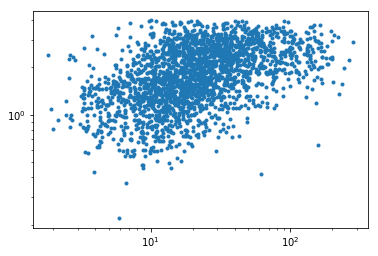

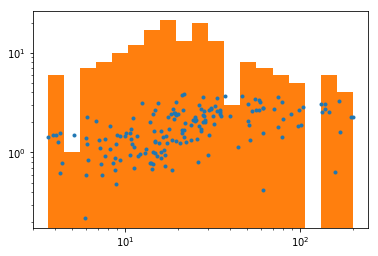

In [79]:
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_koi_q17_add_dispersions_reduction_reduction_new.csv',sep=',')

prad=[]
a_koi_ratio=[] #use a/R_star dimensionless variance to show the correlation
for i in range(0,len(koi_table)):
    if koi_table['koi_disposition'][i]!='FALSE POSITIVE' and koi_table['koi_period'][i]<365 and koi_table['koi_prad'][i]<4:
        prad.append(koi_table['koi_prad'][i])
        a_koi_ratio.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value*c.au.value/(koi_table['rad_b2018'][i]*c.R_sun.value))    

        
print(max(prad),min(prad))
bins=np.logspace(np.log10(min(prad)),np.log10(max(prad)),20,10)
fig=plt.figure()
#plt.hist(prad,bins)
plt.xscale('log')
plt.yscale('log')
plt.plot(a_koi_ratio,prad,'.')

koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_koi_q17_add_dispersions_reduction_reduction_2sigma_hot.csv',sep=',')

prad=[]
a_koi_ratio=[]
for i in range(0,len(koi_table)):
    if koi_table['koi_disposition'][i]!='FALSE POSITIVE' and koi_table['koi_period'][i]<365 and koi_table['koi_prad'][i]<4:
        prad.append(koi_table['koi_prad'][i])
        a_koi_ratio.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value*c.au.value/(koi_table['rad_b2018'][i]*c.R_sun.value))    

        
print(max(prad),min(prad))
bins=np.logspace(np.log10(min(prad)),np.log10(max(prad)),20,10)
fig=plt.figure()
#plt.hist(prad,bins)
plt.xscale('log')
plt.yscale('log')
plt.plot(a_koi_ratio,prad,'.')

bins=np.logspace(np.log10(min(a_koi_ratio)),np.log10(max(a_koi_ratio)),20,10)
plt.hist(a_koi_ratio,bins)

In [51]:
bins_a=np.logspace(math.log(0.005,10),math.log(2,10),25,base=10)
a_koi=[] #use a/R_star dimensionless variance to show the correlation
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value)    

print(max(a_koi),min(a_koi))

1.4769087449895466 0.005879965809567125


/home/dyz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
/home/dyz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in double_scalars


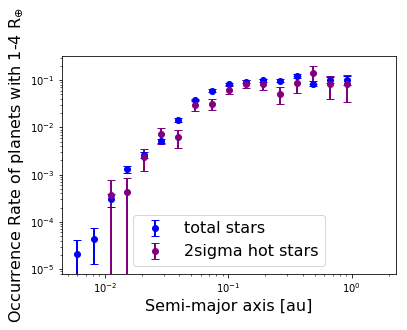

In [16]:
stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_stellar_q17_add_dispersions_reduction_reduction_2020.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_koi_q17_add_dispersions_reduction_reduction_new.csv',sep=',')
bins_period=np.logspace(math.log(0.4,5),math.log(250,5),13,base=5)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  

bins_t=np.logspace(math.log(120,5),math.log(6000,5),25,base=5)
focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/result/occurrence_rate_total.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
bins_a_ratio=np.logspace(math.log(0.8,10),math.log(600,10),25,base=10)
a_koi_ratio=[] #use a/R_star dimensionless variance to show the correlation
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi_ratio.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value*c.au.value/(koi_table['rad_b2018'][i]*c.R_sun.value))    

bins_a=np.logspace(math.log(0.005,10),math.log(2,10),20,base=10)
a_koi=[] #use a/R_star dimensionless variance to show the correlation
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value)    


f_p=[]
f_p_std=[]
p=[]
p_std=[]
a_ratio=[]
a_ratio_std=[]
semi_a=[]
semi_a_std=[]
for i in range(0,len(bins_a)-1):
    focc_temp=[]
    a_ratio_temp=[]
    a_temp=[]
    for j in range(0,len(f_occurrence_everyplanet)):
        if a_koi[j]<bins_a[i+1] and a_koi[j]>=bins_a[i] and koi_table['koi_disposition'][j]!='FALSE POSITIVE' \
        and koi_table['koi_prad'][j]<=4 and koi_table['koi_prad'][j]>=1 and koi_table['koi_period'][j]<=365:
            focc_temp.append(f_occurrence_everyplanet[j])
            a_ratio_temp.append(a_koi_ratio[j])
            a_temp.append(a_koi[j])
            
    f_p.append(np.sum(focc_temp))
    f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
    a_ratio.append((bins_a_ratio[i+1]+bins_a_ratio[i])/2)
    a_ratio_std.append(np.std(a_ratio_temp))
    semi_a.append((bins_a[i+1]+bins_a[i])/2)
    semi_a_std.append(np.std(a_temp))
    
#plt.errorbar(a_ratio,f_p,yerr=f_p_std,fmt="o",color='blue',elinewidth=2,capsize=4,label='total stars') 
plt.errorbar(semi_a,f_p,yerr=f_p_std,fmt="o",color='blue',elinewidth=2,capsize=4,label='total stars') 


stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_stellar_q17_add_dispersions_reduction_reduction_hot_2020.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_koi_q17_add_dispersions_reduction_reduction_2sigma_hot.csv',sep=',')
bins_period=np.logspace(math.log(0.4,5),math.log(250,5),13,base=5)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  
bins_t=np.logspace(math.log(120,5),math.log(6000,5),25,base=5)
focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/result/occurrence_rate_hot_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']
bins_a_ratio=np.logspace(math.log(0.8,10),math.log(600,10),25,base=10)
a_koi_ratio=[] #use a/R_star dimensionless variance to show the correlation
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi_ratio.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value*c.au.value/(koi_table['rad_b2018'][i]*c.R_sun.value))    

bins_a=np.logspace(math.log(0.005,10),math.log(2,10),20,base=10)
a_koi=[] #use a/R_star dimensionless variance to show the correlation
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value)    

f_p=[]
f_p_std=[]
p=[]
p_std=[]
a_ratio=[]
a_ratio_std=[]
semi_a=[]
semi_a_std=[]

for i in range(0,len(bins_a)-1):
    focc_temp=[]
    a_ratio_temp=[]
    a_temp=[]
    for j in range(0,len(f_occurrence_everyplanet)):
        if a_koi[f_id[j]]<bins_a[i+1] and a_koi[f_id[j]]>=bins_a[i] and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' \
        and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1 and koi_table['koi_period'][f_id[j]]<=365:
            focc_temp.append(f_occurrence_everyplanet[j])
            a_ratio_temp.append(a_koi_ratio[f_id[j]])
            a_temp.append(a_koi[j])
            
    f_p.append(np.sum(focc_temp))
    f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
    a_ratio.append((bins_a_ratio[i+1]+bins_a_ratio[i])/2)
    a_ratio_std.append(np.std(a_ratio_temp))
    semi_a.append((bins_a[i+1]+bins_a[i])/2)
    semi_a_std.append(np.std(a_temp))
    
#plt.errorbar(a_ratio,f_p,yerr=f_p_std,fmt="o",color='purple',elinewidth=2,capsize=4,label='2sigma hot stars') 
plt.errorbar(semi_a,f_p,yerr=f_p_std,fmt="o",color='purple',elinewidth=2,capsize=4,label='2sigma hot stars') 


plt.xscale('log')
plt.yscale('log')
plt.xlabel('Semi-major axis [au]', fontsize=16)
plt.ylabel('Occurrence Rate of planets with 1-4 R$_{\oplus}$',fontsize=16,)
plt.legend(loc='best',fontsize=16)
plt.savefig('result/a_2sigma_total_1_4Rearth_p_365.eps')

In [83]:
print(koi_table.columns)

Index(['kepid', 'ra', 'dec', 'cdpp3', 'cdpp6', 'cdpp12', 'std_vra', 'std_vdec',
       'mean_vra', 'mean_vdec', 'sigma_vra', 'sigma_vdec', 'kepmag', 'teff',
       'logg', 'radius', 'feh', 'mass', 'dens', 'dist', 'av', 'jmag', 'hmag',
       'kmag', 'ra_gaia', 'dec_gaia', 'parallax', 'parallax_error', 'pmra',
       'pmra_error', 'pmdec', 'pmdec_error', 'phot_g_mean_mag', 'teff_b2018',
       'teffe_b2018', 'rad_b2018', 'radep_b2018', 'radem_b2018', 'koi_period',
       'koi_duration', 'koi_depth', 'koi_prad', 'koi_model_snr',
       'koi_disposition', 'koi_pdisposition', 'koi_teq'],
      dtype='object')


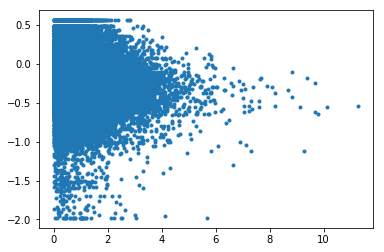

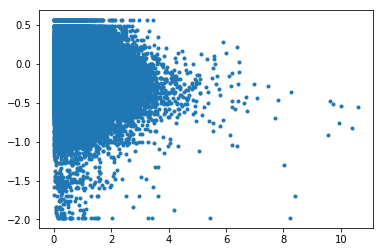

In [30]:
kic_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_stellar_q17_add_dispersions_reduction_2020.csv',sep=',')
fig=plt.figure()
plt.plot(kic_table['sigma_vra'],kic_table['feh'],'.')

fig=plt.figure()
plt.plot(kic_table['sigma_vdec'],kic_table['feh'],'.')

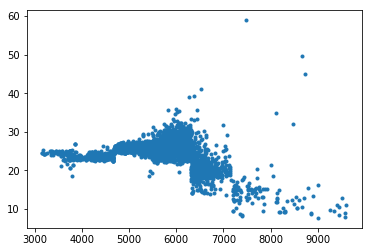

In [89]:
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_koi_q17_add_dispersions_reduction_reduction_new.csv',sep=',')
fig=plt.figure()
plt.plot(koi_table['feh'],koi_table['std_vra'],'.')

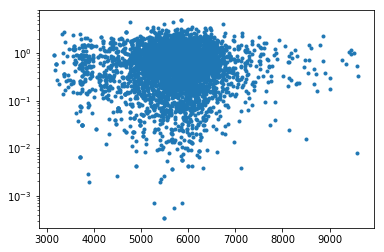

In [93]:
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_koi_q17_add_dispersions_reduction_reduction_new.csv',sep=',')
fig=plt.figure()
plt.plot(koi_table['teff_b2018'],koi_table['sigma_vra'],'.')
plt.yscale('log')


(array([  1.,   0.,   0.,   0.,   1.,   1.,   1.,   1.,   2.,   2.,   0.,
          1.,   0.,   0.,   1.,   0.,   2.,   1.,   3.,   5.,   4.,   5.,
          9.,   9.,  23.,  22.,  21.,  77.,  78., 107.,  95., 215., 149.,
        303., 248., 431., 389., 527., 336., 221., 379., 564., 216.,  71.,
         30.,  84.,  18.,  26.,  18.,  16.]),
 array([-1.92  , -1.8704, -1.8208, -1.7712, -1.7216, -1.672 , -1.6224,
        -1.5728, -1.5232, -1.4736, -1.424 , -1.3744, -1.3248, -1.2752,
        -1.2256, -1.176 , -1.1264, -1.0768, -1.0272, -0.9776, -0.928 ,
        -0.8784, -0.8288, -0.7792, -0.7296, -0.68  , -0.6304, -0.5808,
        -0.5312, -0.4816, -0.432 , -0.3824, -0.3328, -0.2832, -0.2336,
        -0.184 , -0.1344, -0.0848, -0.0352,  0.0144,  0.064 ,  0.1136,
         0.1632,  0.2128,  0.2624,  0.312 ,  0.3616,  0.4112,  0.4608,
         0.5104,  0.56  ]),
 <a list of 50 Patch objects>)

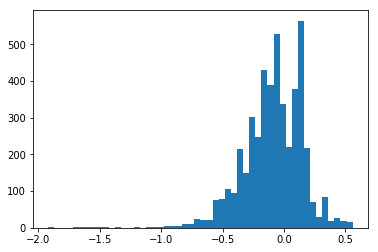

In [96]:
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_koi_q17_add_dispersions_reduction_reduction_new.csv',sep=',')
plt.hist(koi_table['feh'],50)

(array([3.6000e+01, 1.1000e+01, 1.0000e+01, 5.0000e+00, 9.0000e+00,
        1.5000e+01, 5.0000e+00, 2.3000e+01, 2.2000e+01, 4.4000e+01,
        1.5000e+01, 1.8000e+01, 1.6000e+01, 1.8000e+01, 2.7000e+01,
        2.1000e+01, 5.7000e+01, 4.8000e+01, 1.2600e+02, 1.4600e+02,
        2.2500e+02, 1.7900e+02, 3.0200e+02, 2.7500e+02, 4.9900e+02,
        8.0600e+02, 8.5100e+02, 2.2190e+03, 1.8260e+03, 4.2810e+03,
        2.6730e+03, 5.2530e+03, 4.2730e+03, 8.2850e+03, 6.7620e+03,
        1.2626e+04, 9.8140e+03, 1.6090e+04, 1.0637e+04, 3.7160e+03,
        9.1120e+03, 2.5530e+03, 2.3300e+03, 3.5440e+03, 1.2690e+03,
        5.5900e+02, 1.0490e+03, 3.4900e+02, 5.6400e+02, 3.4900e+02]),
 array([-1.9800e+00, -1.9292e+00, -1.8784e+00, -1.8276e+00, -1.7768e+00,
        -1.7260e+00, -1.6752e+00, -1.6244e+00, -1.5736e+00, -1.5228e+00,
        -1.4720e+00, -1.4212e+00, -1.3704e+00, -1.3196e+00, -1.2688e+00,
        -1.2180e+00, -1.1672e+00, -1.1164e+00, -1.0656e+00, -1.0148e+00,
        -9.6400e-01, -9.13

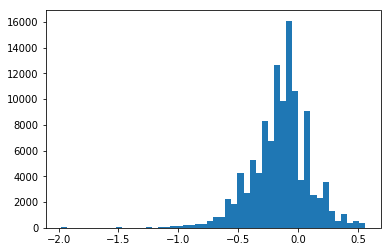

In [97]:
kic_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_stellar_q17_add_dispersions_reduction_reduction_2020.csv',sep=',')
plt.hist(kic_table['feh'],50)

Ks_2sampResult(statistic=0.1397505525451075, pvalue=1.773058395670197e-77)


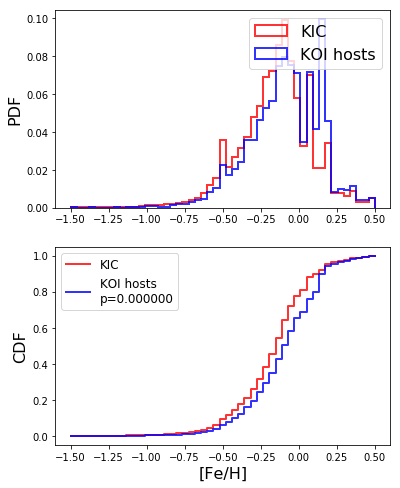

In [20]:
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_koi_q17_add_dispersions_reduction_reduction_new.csv',sep=',')
kic_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_stellar_q17_add_dispersions_reduction_reduction_2020.csv',sep=',')


from scipy import stats
import statsmodels.api as sm
s1=stats.ks_2samp(kic_table['feh'],koi_table['feh'])
plt.figure(figsize=(6,8))
ax1=plt.subplot(2,1,1)
bins=np.linspace(-1.5,0.5,50)
weights1 = np.ones_like(kic_table['feh'])/float(len(kic_table['feh']))

ax1.hist(kic_table['feh'],bins,histtype="step",weights=weights1,color='red',linewidth=2,alpha=0.8,label='KIC')

weights2 = np.ones_like(koi_table['feh'])/float(len(koi_table['feh']))
ax1.hist(koi_table['feh'],bins,histtype="step",weights=weights2,color='blue',linewidth=2,alpha=0.8,label='KOI hosts')
#ax1.grid(True)
#plt.setp(ax15.get_xticklabels(), visible=False)
ax1.legend(loc='best',fontsize=16)
ax1.set_ylabel("PDF",fontsize=16)
#ax1.set_xscale('log')
#ax1.set_xlim(1,1000)

ax2=plt.subplot(2,1,2)
ecdf=sm.distributions.ECDF(kic_table['feh'])
counts1=ecdf(bins)
ax2.step(bins,counts1,color='red',linewidth=2,alpha=0.8,label='KIC')#
ecdf=sm.distributions.ECDF(koi_table['feh'])
counts2=ecdf(bins)
ax2.step(bins,counts2,color='blue',linewidth=2,alpha=0.8,label='KOI hosts'+'\n'+'p='+'{:5f}'.format(s1[1]))
ax2.set_xlabel("[Fe/H]",fontsize=16)
ax2.set_ylabel("CDF",fontsize=16)
#ax2.set_xlim(1,1000)
ax2.legend(loc='best',fontsize=12)
#ax2.set_xscale('log')
plt.savefig("result/KIC_KOI_feh.eps")
print(s1)


Ks_2sampResult(statistic=0.10685402074513345, pvalue=1.7972415382731373e-45)


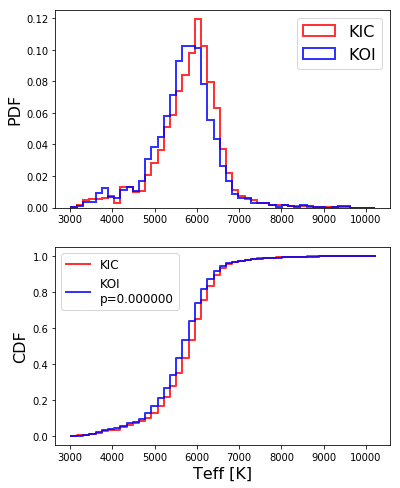

In [19]:
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_koi_q17_add_dispersions_reduction_reduction_new.csv',sep=',')
kic_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_stellar_q17_add_dispersions_reduction_reduction_2020.csv',sep=',')


from scipy import stats
import statsmodels.api as sm
s1=stats.ks_2samp(kic_table['teff_b2018'],koi_table['teff_b2018'])
plt.figure(figsize=(6,8))
ax1=plt.subplot(2,1,1)
bins=np.linspace(min(min(kic_table['teff_b2018']),min(koi_table['teff_b2018'])),max(max(kic_table['teff_b2018']),max(koi_table['teff_b2018'])))
weights1 = np.ones_like(kic_table['teff_b2018'])/float(len(kic_table['teff_b2018']))

ax1.hist(kic_table['teff_b2018'],bins,histtype="step",weights=weights1,color='red',linewidth=2,alpha=0.8,label='KIC')

weights2 = np.ones_like(koi_table['teff_b2018'])/float(len(koi_table['teff_b2018']))
ax1.hist(koi_table['teff_b2018'],bins,histtype="step",weights=weights2,color='blue',linewidth=2,alpha=0.8,label='KOI')
#ax1.grid(True)
#plt.setp(ax15.get_xticklabels(), visible=False)
ax1.legend(loc='best',fontsize=16)
ax1.set_ylabel("PDF",fontsize=16)
#ax1.set_xscale('log')
#ax1.set_xlim(1,1000)

ax2=plt.subplot(2,1,2)
ecdf=sm.distributions.ECDF(kic_table['teff_b2018'])
counts1=ecdf(bins)
ax2.step(bins,counts1,color='red',linewidth=2,alpha=0.8,label='KIC')#
ecdf=sm.distributions.ECDF(koi_table['teff_b2018'])
counts2=ecdf(bins)
ax2.step(bins,counts2,color='blue',linewidth=2,alpha=0.8,label='KOI'+'\n'+'p='+'{:5f}'.format(s1[1]))
ax2.set_xlabel("Teff [K]",fontsize=16)
ax2.set_ylabel("CDF",fontsize=16)
#ax2.set_xlim(1,1000)
ax2.legend(loc='best',fontsize=12)
#ax2.set_xscale('log')
plt.savefig("result/koi_kic_teff_b2018.eps")
print(s1)

Ks_2sampResult(statistic=0.20399999999999996, pvalue=1.3137914639084031e-09)
-0.23686882933709005 -0.1424356829718925


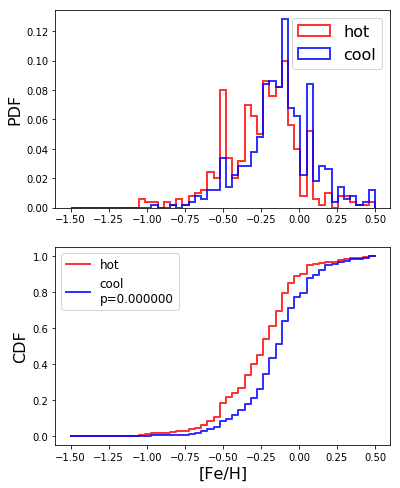

In [4]:
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_stellar_q17_add_dispersions_reduction_reduction_cool_2020.csv',sep=',')
kic_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_stellar_q17_add_dispersions_reduction_reduction_hot_2020.csv',sep=',')


from scipy import stats
import statsmodels.api as sm
s1=stats.ks_2samp(kic_table['feh'][0:500],koi_table['feh'][0:500])
plt.figure(figsize=(6,8))
ax1=plt.subplot(2,1,1)
bins=np.linspace(-1.5,0.5,50)
weights1 = np.ones_like(kic_table['feh'][0:500])/float(len(kic_table['feh'][0:500]))

ax1.hist(kic_table['feh'][0:500],bins,histtype="step",weights=weights1,color='red',linewidth=2,alpha=0.8,label='hot')

weights2 = np.ones_like(koi_table['feh'][0:500])/float(len(koi_table['feh'][0:500]))
ax1.hist(koi_table['feh'][0:500],bins,histtype="step",weights=weights2,color='blue',linewidth=2,alpha=0.8,label='cool')
#ax1.grid(True)
#plt.setp(ax15.get_xticklabels(), visible=False)
ax1.legend(loc='best',fontsize=16)
ax1.set_ylabel("PDF",fontsize=16)
#ax1.set_xscale('log')
#ax1.set_xlim(1,1000)

ax2=plt.subplot(2,1,2)
ecdf=sm.distributions.ECDF(kic_table['feh'][0:500])
counts1=ecdf(bins)
ax2.step(bins,counts1,color='red',linewidth=2,alpha=0.8,label='hot')#
ecdf=sm.distributions.ECDF(koi_table['feh'][0:500])
counts2=ecdf(bins)
ax2.step(bins,counts2,color='blue',linewidth=2,alpha=0.8,label='cool'+'\n'+'p='+'{:5f}'.format(s1[1]))
ax2.set_xlabel("[Fe/H]",fontsize=16)
ax2.set_ylabel("CDF",fontsize=16)
#ax2.set_xlim(1,1000)
ax2.legend(loc='best',fontsize=12)
#ax2.set_xscale('log')
plt.savefig("result/cool_hot_feh.eps")
print(s1)
print(np.mean(kic_table['feh']),np.mean(koi_table['feh']))


Ks_2sampResult(statistic=0.11932183328140311, pvalue=9.059859290577958e-113)
1.002414436240556 0.9433828329639322


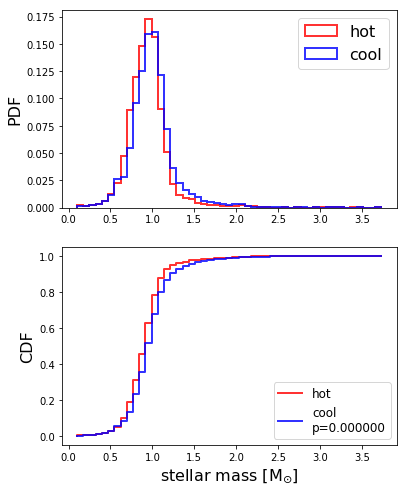

In [3]:
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_stellar_q17_add_dispersions_reduction_reduction_cool_2020.csv',sep=',')
kic_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_stellar_q17_add_dispersions_reduction_reduction_hot_2020.csv',sep=',')


from scipy import stats
import statsmodels.api as sm
s1=stats.ks_2samp(kic_table['mass'],koi_table['mass'])
plt.figure(figsize=(6,8))
ax1=plt.subplot(2,1,1)
bins=np.linspace(min(min(kic_table['mass']),min(koi_table['mass'])),max(max(kic_table['mass']),max(koi_table['mass'])))
weights1 = np.ones_like(kic_table['mass'])/float(len(kic_table['mass']))

ax1.hist(kic_table['mass'],bins,histtype="step",weights=weights1,color='red',linewidth=2,alpha=0.8,label='hot')

weights2 = np.ones_like(koi_table['mass'])/float(len(koi_table['mass']))
ax1.hist(koi_table['mass'],bins,histtype="step",weights=weights2,color='blue',linewidth=2,alpha=0.8,label='cool')
#ax1.grid(True)
#plt.setp(ax15.get_xticklabels(), visible=False)
ax1.legend(loc='best',fontsize=16)
ax1.set_ylabel("PDF",fontsize=16)
#ax1.set_xscale('log')
#ax1.set_xlim(1,1000)

ax2=plt.subplot(2,1,2)
ecdf=sm.distributions.ECDF(kic_table['mass'])
counts1=ecdf(bins)
ax2.step(bins,counts1,color='red',linewidth=2,alpha=0.8,label='hot')#
ecdf=sm.distributions.ECDF(koi_table['mass'])
counts2=ecdf(bins)
ax2.step(bins,counts2,color='blue',linewidth=2,alpha=0.8,label='cool'+'\n'+'p='+'{:5f}'.format(s1[1]))
ax2.set_xlabel("stellar mass [M$_{\odot}$]",fontsize=16)
ax2.set_ylabel("CDF",fontsize=16)
#ax2.set_xlim(1,1000)
ax2.legend(loc='best',fontsize=12)
#ax2.set_xscale('log')
plt.savefig("result/cool_hot_mass.eps")
print(s1)
print(np.mean(koi_table['mass']),np.mean(kic_table['mass']))

Ks_2sampResult(statistic=0.0535427108301787, pvalue=4.787431974000349e-23)
5817.315682202738 5753.587447108604


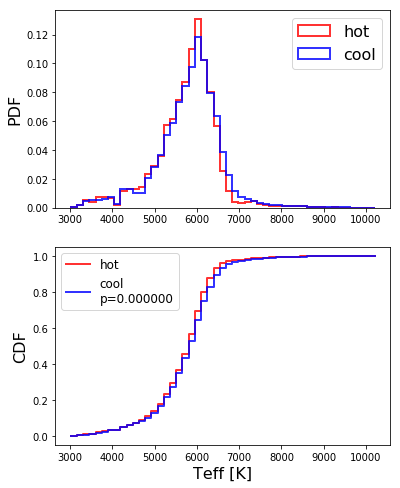

In [2]:
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_stellar_q17_add_dispersions_reduction_reduction_cool_2020.csv',sep=',')
kic_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_stellar_q17_add_dispersions_reduction_reduction_hot_2020.csv',sep=',')


from scipy import stats
import statsmodels.api as sm
s1=stats.ks_2samp(kic_table['teff_b2018'],koi_table['teff_b2018'])
plt.figure(figsize=(6,8))
ax1=plt.subplot(2,1,1)
bins=np.linspace(min(min(kic_table['teff_b2018']),min(koi_table['teff_b2018'])),max(max(kic_table['teff_b2018']),max(koi_table['teff_b2018'])))
weights1 = np.ones_like(kic_table['teff_b2018'])/float(len(kic_table['teff_b2018']))

ax1.hist(kic_table['teff_b2018'],bins,histtype="step",weights=weights1,color='red',linewidth=2,alpha=0.8,label='hot')

weights2 = np.ones_like(koi_table['teff_b2018'])/float(len(koi_table['teff_b2018']))
ax1.hist(koi_table['teff_b2018'],bins,histtype="step",weights=weights2,color='blue',linewidth=2,alpha=0.8,label='cool')
#ax1.grid(True)
#plt.setp(ax15.get_xticklabels(), visible=False)
ax1.legend(loc='best',fontsize=16)
ax1.set_ylabel("PDF",fontsize=16)
#ax1.set_xscale('log')
#ax1.set_xlim(1,1000)

ax2=plt.subplot(2,1,2)
ecdf=sm.distributions.ECDF(kic_table['teff_b2018'])
counts1=ecdf(bins)
ax2.step(bins,counts1,color='red',linewidth=2,alpha=0.8,label='hot')#
ecdf=sm.distributions.ECDF(koi_table['teff_b2018'])
counts2=ecdf(bins)
ax2.step(bins,counts2,color='blue',linewidth=2,alpha=0.8,label='cool'+'\n'+'p='+'{:5f}'.format(s1[1]))
ax2.set_xlabel("Teff [K]",fontsize=16)
ax2.set_ylabel("CDF",fontsize=16)
#ax2.set_xlim(1,1000)
ax2.legend(loc='best',fontsize=12)
#ax2.set_xscale('log')
plt.savefig("result/cool_hot_teff_b2018.eps")
print(s1)
print(np.mean(koi_table['teff_b2018']),np.mean(kic_table['teff_b2018']))

In [ ]:
print(hot)

In [100]:
print(kic_table.columns)

Index(['kepid', 'ra', 'dec', 'cdpp3', 'cdpp6', 'cdpp12', 'st_quarters',
       't_obs', 'std_vra', 'std_vdec', 'mean_vra', 'mean_vdec', 'sigma_vra',
       'sigma_vdec', 'kepmag', 'teff', 'logg', 'radius', 'feh', 'mass', 'dens',
       'dist', 'av', 'jmag', 'hmag', 'kmag', 'ra_gaia', 'dec_gaia', 'parallax',
       'parallax_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error',
       'phot_g_mean_mag', 'teff_b2018', 'teffe_b2018', 'rad_b2018',
       'radep_b2018', 'radem_b2018'],
      dtype='object')


1.5363133965204748e-16 30856775814671.914


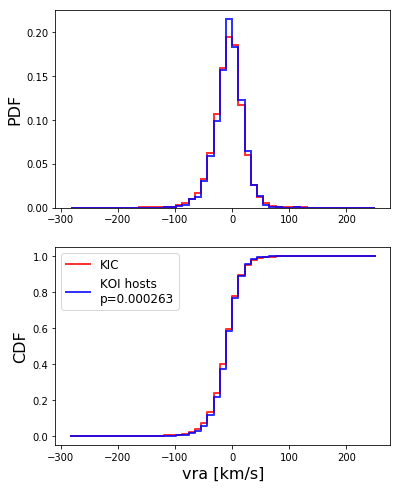

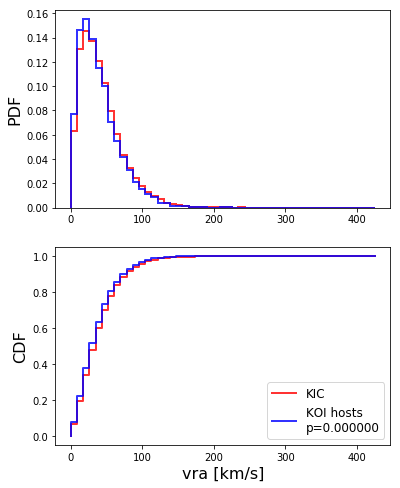

In [8]:
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_koi_q17_add_dispersions_reduction_reduction_new.csv',sep=',')
kic_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_stellar_q17_add_dispersions_reduction_reduction_2020.csv',sep=',')


from scipy import stats
import statsmodels.api as sm
c1=1./1e3/3600e0*np.pi/180e0/(24e0*3600e0*365.2425e0)
c2=c.pc.value/1000
print(c1,c2)

kic_vra=[]
kic_vdec=[]
kic_vtot=[]
for i in range(0,len(kic_table)):
    temp1=kic_table['pmra'][i]*c1*1e3/kic_table['parallax'][i]*c2
    temp2=kic_table['pmdec'][i]*c1*1e3/kic_table['parallax'][i]*c2
    kic_vra.append(temp1)
    kic_vdec.append(temp2)
    kic_vtot.append((temp1**2+temp2**2)**0.5)

                    
                    
koi_vra=[]
koi_vdec=[]
koi_vtot=[]
for i in range(0,len(koi_table)):
    temp1=koi_table['pmra'][i]*c1*1e3/koi_table['parallax'][i]*c2
    temp2=koi_table['pmdec'][i]*c1*1e3/koi_table['parallax'][i]*c2
    koi_vra.append(temp1)
    koi_vdec.append(temp2)
    koi_vtot.append((temp1**2+temp2**2)**0.5)
                    
    
    
s1=stats.ks_2samp(kic_vra,koi_vra)
plt.figure(figsize=(6,8))
ax1=plt.subplot(2,1,1)
bins=np.linspace(min(min(koi_vra),min(kic_vra)),max(max(koi_vra),max(kic_vra)),50)
weights1 = np.ones_like(kic_vra)/float(len(kic_vra))

ax1.hist(kic_vra,bins,histtype="step",weights=weights1,color='red',linewidth=2,alpha=0.8,label='KIC')

weights2 = np.ones_like(koi_vra)/float(len(koi_vra))
ax1.hist(koi_vra,bins,histtype="step",weights=weights2,color='blue',linewidth=2,alpha=0.8,label='KOI hosts')
#ax1.grid(True)
#plt.setp(ax15.get_xticklabels(), visible=False)
#ax1.legend(loc='best',fontsize=16)
ax1.set_ylabel("PDF",fontsize=16)
#ax1.set_xscale('log')
#ax1.set_xlim(1,1000)

ax2=plt.subplot(2,1,2)
ecdf=sm.distributions.ECDF(kic_vra)
counts1=ecdf(bins)
ax2.step(bins,counts1,color='red',linewidth=2,alpha=0.8,label='KIC')#
ecdf=sm.distributions.ECDF(koi_vra)
counts2=ecdf(bins)
ax2.step(bins,counts2,color='blue',linewidth=2,alpha=0.8,label='KOI hosts'+'\n'+'p='+'{:5f}'.format(s1[1]))
ax2.set_xlabel("vra [km/s]",fontsize=16)
ax2.set_ylabel("CDF",fontsize=16)
#ax2.set_xlim(1,1000)
ax2.legend(loc='best',fontsize=12)
#ax2.set_xscale('log')
plt.savefig("result/KIC_KOI_vra.eps")



#vtot 2d
s1=stats.ks_2samp(kic_vtot,koi_vtot)
plt.figure(figsize=(6,8))
ax1=plt.subplot(2,1,1)
bins=np.linspace(min(min(koi_vtot),min(kic_vtot)),max(max(koi_vtot),max(kic_vtot)),50)
weights1 = np.ones_like(kic_vtot)/float(len(kic_vtot))

ax1.hist(kic_vtot,bins,histtype="step",weights=weights1,color='red',linewidth=2,alpha=0.8,label='KIC')

weights2 = np.ones_like(koi_vtot)/float(len(koi_vtot))
ax1.hist(koi_vtot,bins,histtype="step",weights=weights2,color='blue',linewidth=2,alpha=0.8,label='KOI hosts')
#ax1.grid(True)
#plt.setp(ax15.get_xticklabels(), visible=False)
#ax1.legend(loc='best',fontsize=16)
ax1.set_ylabel("PDF",fontsize=16)
#ax1.set_xscale('log')
#ax1.set_xlim(1,1000)

ax2=plt.subplot(2,1,2)
ecdf=sm.distributions.ECDF(kic_vtot)
counts1=ecdf(bins)
ax2.step(bins,counts1,color='red',linewidth=2,alpha=0.8,label='KIC')#
ecdf=sm.distributions.ECDF(koi_vtot)
counts2=ecdf(bins)
ax2.step(bins,counts2,color='blue',linewidth=2,alpha=0.8,label='KOI hosts'+'\n'+'p='+'{:5f}'.format(s1[1]))
ax2.set_xlabel("vra [km/s]",fontsize=16)
ax2.set_ylabel("CDF",fontsize=16)
#ax2.set_xlim(1,1000)
ax2.legend(loc='best',fontsize=12)
#ax2.set_xscale('log')
plt.savefig("result/KIC_KOI_vtot.eps")

In [10]:
#creat the similar FeH distribution to show that this different will not show great difference
stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_stellar_q17_add_dispersions_reduction_reduction_2020.csv',sep=',')

stellar_hot=pd.read_csv('data/kepler_stellar_q17_add_dispersions_reduction_reduction_hot_2020.csv',sep=',')
stellar_cool=pd.read_csv('data/kepler_stellar_q17_add_dispersions_reduction_reduction_cool_2020.csv',sep=',')


feh=[]
for i in range(0,len(stellar_hot)):
    for j in range(0,len(stellar_table)):
        if abs(stellar_hot['feh'][i]-stellar_table['feh'][j])<0.01:
            feh.append(stellar_table['feh'][j])


SyntaxError: EOL while scanning string literal (<ipython-input-10-8e333e70a293>, line 13)

In [5]:
from __future__ import print_function, division
from PyAstronomy import pyasl

# Create class instance
r = pyasl.Ramirez2005()


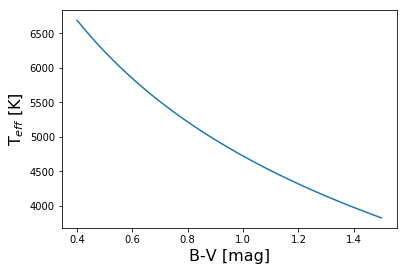

In [14]:
bv = np.linspace(0.4,1.5,1000)
feh =0
teff=[]
for i in range(0,len(bv)):
    teff.append(r.colorToTeff("B-V", bv[i], 0))
    

fig=plt.figure()
plt.plot(bv,teff)
plt.xlabel("B-V [mag]",fontsize=16)
plt.ylabel("T$_{eff}$ [K]",fontsize=16)
plt.savefig('teff_bv.png',dpi=300)

In [15]:
stellar_hot=pd.read_csv('data/kepler_stellar_q17_add_dispersions_reduction_reduction_hot_2020.csv',sep=',')
stellar_cool=pd.read_csv('data/kepler_stellar_q17_add_dispersions_reduction_reduction_cool_2020.csv',sep=',')


In [16]:
print(len(stellar_hot),len(stellar_cool))

9926 104016


Ks_2sampResult(statistic=0.17602864643989274, pvalue=6.344836527298438e-245)
-0.23686882933709005 -0.1424356829718925


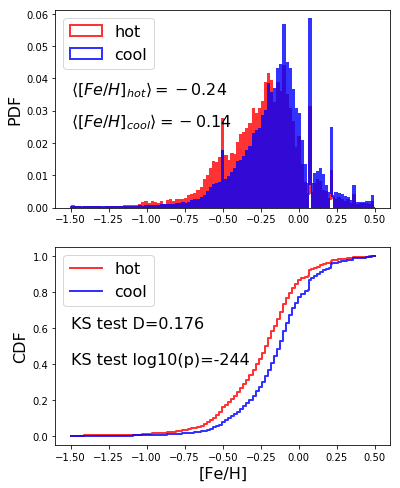

In [76]:
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_stellar_q17_add_dispersions_reduction_reduction_cool_2020.csv',sep=',')
kic_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_stellar_q17_add_dispersions_reduction_reduction_hot_2020.csv',sep=',')


from scipy import stats
import statsmodels.api as sm
s1=stats.ks_2samp(kic_table['feh'],koi_table['feh'])
fig=plt.figure(figsize=(6,8))
ax1=plt.subplot(2,1,1)
bins=np.linspace(-1.5,0.5,200)
weights1 = np.ones_like(kic_table['feh'])/float(len(kic_table['feh']))

ax1.hist(kic_table['feh'],bins,histtype="step",weights=weights1,color='red',linewidth=2,alpha=0.8,label='hot')# $\langle \; \rangle$')#+'$\langle$ [Fe/H] $\rangle$ = ')#+'{:2f}'.format(np.mean(kic_table['feh'])))

weights2 = np.ones_like(koi_table['feh'])/float(len(koi_table['feh']))
ax1.hist(koi_table['feh'],bins,histtype="step",weights=weights2,color='blue',linewidth=2,alpha=0.8,label='cool')#+'$\langle$ [Fe/H] $\rangle$ = ')#+'{:2f}'.format(np.mean(koi_table['feh'])))
#ax1.grid(True)
#plt.setp(ax15.get_xticklabels(), visible=False)
ax1.legend(loc='upper left',fontsize=16)
ax1.set_ylabel("PDF",fontsize=16)
ax1.text(-1.5,0.035,'$\langle[Fe/H]_{hot}\\rangle=-0.24$',fontsize=16)#,fontweight='bold')
ax1.text(-1.5,0.025,'$\langle[Fe/H]_{cool}\\rangle=-0.14$',fontsize=16)#,fontweight='bold')


#ax1.set_xscale('log')
#ax1.set_xlim(1,1000)

ax2=plt.subplot(2,1,2)
ecdf=sm.distributions.ECDF(kic_table['feh'])
counts1=ecdf(bins)
ax2.step(bins,counts1,color='red',linewidth=2,alpha=0.8,label='hot')#
ecdf=sm.distributions.ECDF(koi_table['feh'])
counts2=ecdf(bins)
ax2.step(bins,counts2,color='blue',linewidth=2,alpha=0.8,label='cool')
ax2.set_xlabel("[Fe/H]",fontsize=16)
ax2.set_ylabel("CDF",fontsize=16)
#ax2.set_xlim(1,1000)
ax2.legend(loc='best',fontsize=16)
#ax2.set_xscale('log')
ax2.text(-1.5,0.6,'KS test D=0.176',fontsize=16)#,fontweight='bold')
ax2.text(-1.5,0.4,'KS test log10(p)=-244',fontsize=16)#,fontweight='bold')
plt.savefig("result/cool_hot_feh.eps")

print(s1)
print(np.mean(kic_table['feh']),np.mean(koi_table['feh']))


In [53]:
np.log10(6.344836527298438e-245)

-244.19757956288478

Ks_2sampResult(statistic=0.11932183328140311, pvalue=9.059859290577958e-113)
1.002414436240556 0.9433828329639322
0.2741660666031197 0.24411256483716232


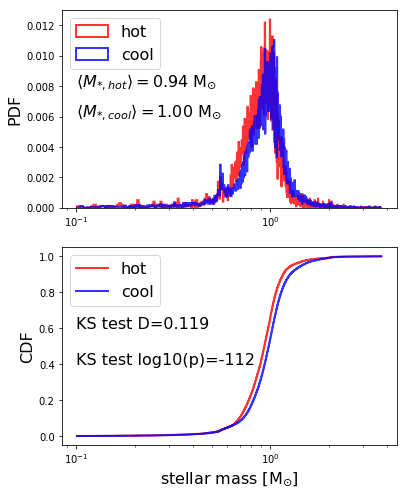

In [77]:
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_stellar_q17_add_dispersions_reduction_reduction_cool_2020.csv',sep=',')
kic_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_stellar_q17_add_dispersions_reduction_reduction_hot_2020.csv',sep=',')


from scipy import stats
import statsmodels.api as sm
s1=stats.ks_2samp(kic_table['mass'],koi_table['mass'])
plt.figure(figsize=(6,8))
ax1=plt.subplot(2,1,1)
bins=np.linspace(min(min(kic_table['mass']),min(koi_table['mass'])),max(max(kic_table['mass']),max(koi_table['mass'])),1000)
weights1 = np.ones_like(kic_table['mass'])/float(len(kic_table['mass']))

ax1.hist(kic_table['mass'],bins,histtype="step",weights=weights1,color='red',linewidth=2,alpha=0.8,label='hot')

weights2 = np.ones_like(koi_table['mass'])/float(len(koi_table['mass']))
ax1.hist(koi_table['mass'],bins,histtype="step",weights=weights2,color='blue',linewidth=2,alpha=0.8,label='cool')
#ax1.grid(True)
#plt.setp(ax15.get_xticklabels(), visible=False)
ax1.legend(loc='upper left',fontsize=16)
ax1.set_ylabel("PDF",fontsize=16)
ax1.set_xscale('log')
#ax1.set_xlim(1,1000)
ax1.text(0.1,0.008,'$\langle M_{*,hot}\\rangle=0.94$ M$_{\odot}$',fontsize=16)#,fontweight='bold')
ax1.text(0.1,0.006,'$\langle M_{*,cool}\\rangle=1.00$ M$_{\odot}$',fontsize=16)#,fontweight='bold')

ax2=plt.subplot(2,1,2)
ecdf=sm.distributions.ECDF(kic_table['mass'])
counts1=ecdf(bins)
ax2.step(bins,counts1,color='red',linewidth=2,alpha=0.8,label='hot')#
ecdf=sm.distributions.ECDF(koi_table['mass'])
counts2=ecdf(bins)
ax2.step(bins,counts2,color='blue',linewidth=2,alpha=0.8,label='cool')#+'\n'+'p='+'{:5f}'.format(s1[1]))
ax2.set_xlabel("stellar mass [M$_{\odot}$]",fontsize=16)
ax2.set_ylabel("CDF",fontsize=16)
#ax2.set_xlim(1,1000)
ax2.legend(loc='best',fontsize=16)
ax2.set_xscale('log')
ax2.text(0.1,0.6,'KS test D=0.119',fontsize=16)#,fontweight='bold')
ax2.text(0.1,0.4,'KS test log10(p)=-112',fontsize=16)#,fontweight='bold')
plt.savefig("result/cool_hot_mass.eps")
print(s1)
print(np.mean(koi_table['mass']),np.mean(kic_table['mass']))
print(np.std(koi_table['mass']),np.std(kic_table['mass']))

In [2]:
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_stellar_q17_add_dispersions_reduction_reduction_cool_2020.csv',sep=',')
kic_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_stellar_q17_add_dispersions_reduction_reduction_hot_2020.csv',sep=',')
print(len(kic_table))

9926


Ks_2sampResult(statistic=0.0535427108301787, pvalue=4.787431974000349e-23)
5817.315682202738 5753.587447108604


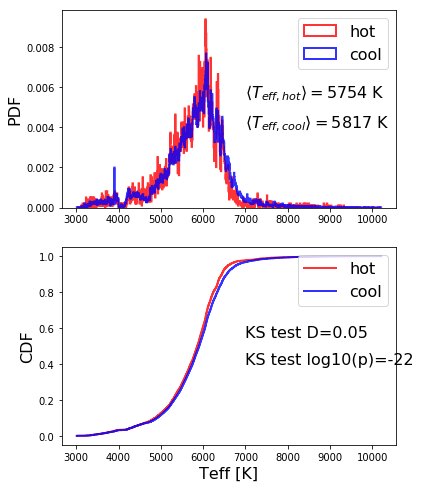

In [75]:
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_stellar_q17_add_dispersions_reduction_reduction_cool_2020.csv',sep=',')
kic_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_stellar_q17_add_dispersions_reduction_reduction_hot_2020.csv',sep=',')


from scipy import stats
import statsmodels.api as sm
s1=stats.ks_2samp(kic_table['teff_b2018'],koi_table['teff_b2018'])
plt.figure(figsize=(6,8))
ax1=plt.subplot(2,1,1)
bins=np.linspace(min(min(kic_table['teff_b2018']),min(koi_table['teff_b2018'])),max(max(kic_table['teff_b2018']),max(koi_table['teff_b2018'])),1000)
weights1 = np.ones_like(kic_table['teff_b2018'])/float(len(kic_table['teff_b2018']))

ax1.hist(kic_table['teff_b2018'],bins,histtype="step",weights=weights1,color='red',linewidth=2,alpha=0.8,label='hot')

weights2 = np.ones_like(koi_table['teff_b2018'])/float(len(koi_table['teff_b2018']))
ax1.hist(koi_table['teff_b2018'],bins,histtype="step",weights=weights2,color='blue',linewidth=2,alpha=0.8,label='cool')
#ax1.grid(True)
#plt.setp(ax15.get_xticklabels(), visible=False)
ax1.legend(loc='best',fontsize=16)
ax1.set_ylabel("PDF",fontsize=16)
ax1.text(7000,0.0055,'$\langle T_{eff,hot}\\rangle=5754$ K',fontsize=16)#,fontweight='bold')
ax1.text(7000,0.004,'$\langle T_{eff,cool}\\rangle=5817$ K',fontsize=16)#,fontweight='bold')
#ax1.set_xscale('log')
#ax1.set_xlim(1,1000)

ax2=plt.subplot(2,1,2)
ecdf=sm.distributions.ECDF(kic_table['teff_b2018'])
counts1=ecdf(bins)
ax2.step(bins,counts1,color='red',linewidth=2,alpha=0.8,label='hot')#
ecdf=sm.distributions.ECDF(koi_table['teff_b2018'])
counts2=ecdf(bins)
ax2.step(bins,counts2,color='blue',linewidth=2,alpha=0.8,label='cool')#+'\n'+'p='+'{:5f}'.format(s1[1]))
ax2.set_xlabel("Teff [K]",fontsize=16)
ax2.set_ylabel("CDF",fontsize=16)
#ax2.set_xlim(1,1000)
ax2.legend(loc='upper right',fontsize=16)
ax2.text(7000,0.55,'KS test D=0.05',fontsize=16)#,fontweight='bold')
ax2.text(7000,0.4,'KS test log10(p)=-22',fontsize=16)#,fontweight='bold')

#ax2.set_xscale('log')
plt.savefig("result/cool_hot_teff_b2018.eps")
print(s1)
print(np.mean(koi_table['teff_b2018']),np.mean(kic_table['teff_b2018']))

In [69]:
np.log10(4.787431974000349e-23)

-22.319897383994846

In [3]:
data = pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_koi_q17_add_dispersions_reduction_reduction_new.csv',sep=',')


In [12]:
#include false positive compare with the calculated SNR and tableed SNR
stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_stellar_q17_add_dispersions_reduction_reduction_2020.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_koi_q17_add_dispersions_reduction_reduction_new.csv',sep=',')

# calculate the SNR
from scipy.optimize import curve_fit
data = pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_koi_q17_add_dispersions_reduction_reduction_new.csv',sep=',')
t_obs=1415 #day
SNR_calculate=[]
for i in range(0,len(data)):
    # the transit number n
    n_temp=n(t_obs,data['koi_period'][i])
    x=[3,6,12]
    y=[data['cdpp3'][i],data['cdpp6'][i],data['cdpp12'][i]]
    popt, pcov = curve_fit(sigma_s, x, y)
    sigma_LC=popt[0]
    cdppindex=popt[1]
    sm_axis=a(data['mass'][i],data['koi_period'][i]) #unit m
    t_duration=t_dur(data['koi_period'][i],data['rad_b2018'][i],0.1,sm_axis) #unit hour
    sigma_s_temp=sigma_s(data['koi_duration'][i],sigma_LC,cdppindex) #unit ppm
    depth=delta(data['koi_prad'][i], data['rad_b2018'][i]) #unit ppm
    SNR_temp=SNR(data['koi_depth'][i],n_temp,sigma_s_temp) #1
    SNR_calculate.append(SNR_temp)

In [5]:
print(SNR_calculate)

[8.08591150036104, 786.6337229921771, 27.017300270286885, 37.329683819667764, 87.05738579500266, 23.429118581057793, 16.695275690025237, 13.497780625732625, 17.046067182785816, 13.06690591841111, 20.15361596695421, 5346.186290871079, 29.017457065603594, 95.06253502349918, 11.38575236030281, 41.42390450762803, 728.0638677062283, 14.910993898644822, 7400.301800492077, 23.459133255932556, 10.88981652799656, 29.67098097390858, 31.66931940699891, 24.775174343342197, 25.323744411590315, 43.417123400749446, 86.38063101495074, 13.48703597329699, 17.742325848709218, 18.050887960170655, 278.3451513550461, 1879.9094261129194, 64.30506797162349, 41.78738888247492, 52.98424302077418, 198.87950006511932, 13.917357940783358, 12.113309649809716, 8.82292584635464, 1506.025765460828, 133.34113708021596, 38.233948403262154, 43.972511025469096, 482.9982333430152, 79.83675357565652, 5413.6873738545, 19.417500747408223, 42.30474595760897, 36.166730150027824, 32.84759667947596, 26.943300296745463, 15190.7240

AttributeError: Unknown property size

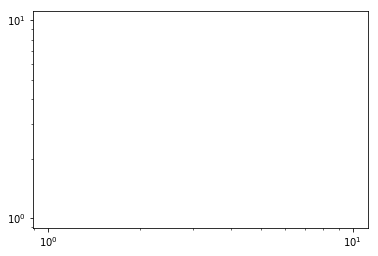

In [15]:
fig=plt.figure()
plt.loglog(data['koi_model_snr'],SNR_calculate,'.',size=1)
plt.xlim(1e0,1e5)
plt.ylim(1e0,1e5)
x=np.linspace(1e0,1e5,10000)
y=np.linspace(1e0,1e5,10000)
plt.plot(x,y,'r-')
plt.xlabel('Tabulated SNR (ppm)')
plt.ylabel('Calculated SNR (ppm)')
plt.savefig('result/SNR_ratio_include_fp.eps',dpi=300)


In [9]:
#include false positive compare with the calculated SNR and tableed SNR
stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_stellar_q17_add_dispersions_reduction_reduction_2020.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_koi_q17_add_dispersions_reduction_reduction_new.csv',sep=',')

# calculate the SNR
from scipy.optimize import curve_fit
data = pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_koi_q17_add_dispersions_reduction_reduction_new.csv',sep=',')
t_obs=1415 #day
SNR_calculate=[]
SNR_tab=[]
for i in range(0,len(data)):
    if data['koi_disposition'][i]!='FALSE POSITIVE':
        # the transit number n
        n_temp=n(t_obs,data['koi_period'][i])
        x=[3,6,12]
        y=[data['cdpp3'][i],data['cdpp6'][i],data['cdpp12'][i]]
        popt, pcov = curve_fit(sigma_s, x, y)
        sigma_LC=popt[0]
        cdppindex=popt[1]
        sm_axis=a(data['mass'][i],data['koi_period'][i]) #unit m
        t_duration=t_dur(data['koi_period'][i],data['rad_b2018'][i],0.1,sm_axis) #unit hour
        sigma_s_temp=sigma_s(data['koi_duration'][i],sigma_LC,cdppindex) #unit ppm
        depth=delta(data['koi_prad'][i], data['rad_b2018'][i]) #unit ppm
        SNR_temp=SNR(data['koi_depth'][i],n_temp,sigma_s_temp) #1
        SNR_calculate.append(SNR_temp)
        SNR_tab.append(data['koi_model_snr'][i])

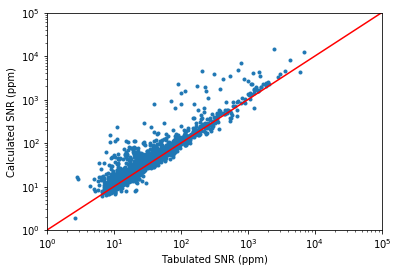

In [10]:
fig=plt.figure()
plt.loglog(SNR_tab,SNR_calculate,'.')
plt.xlim(1e0,1e5)
plt.ylim(1e0,1e5)
x=np.linspace(1e0,1e5,10000)
y=np.linspace(1e0,1e5,10000)
plt.plot(x,y,'r-')
plt.xlabel('Tabulated SNR (ppm)')
plt.ylabel('Calculated SNR (ppm)')
plt.savefig('result/SNR_ratio_exclude_fp.eps',dpi=300)


In [2]:
hot_star=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_stellar_q17_add_dispersions_reduction_reduction_hot_2020.csv',sep=',')
cool_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_stellar_q17_add_dispersions_reduction_reduction_cool_2020.csv',sep=',')


In [3]:
#use LAMOSR metallicity to discuss the difference

LAMOST_DR4=pd.read_csv('data/LAMOST_DR4.csv')
HOT_STAR=pd.read_csv('data/kepler_stellar_q17_add_dispersions_reduction_reduction_hot_2020.csv',sep=',')
COOL_STAR=pd.read_csv('data/kepler_stellar_q17_add_dispersions_reduction_reduction_cool_2020.csv',sep=',')

def b_search(x,list2): #list1 Berger 2018; list Berger 2020    
    low=0
    high=len(list2)-1
    number=0
    while low <= high:
        number+=1
        mid = int((low+high)/2)
        if x<list2[mid]:
            high = mid -1
        elif x>list2[mid]:
            low = mid +1
        elif x==list2[mid]:
            return mid

    
    

In [6]:
HOT_MET_LAMOST=[]
HOT_MET_LAMOST_ERR=[]
HOT_CROSS_KEPID=[]


COOL_MET_LAMOST=[]
COOL_MET_LAMOST_ERR=[]
COOL_CROSS_KEPID=[]

for i in range(0,len(HOT_STAR)):
    key=b_search(HOT_STAR['kepid'][i],LAMOST_DR4['kepid'])
    if key!=None:
        if LAMOST_DR4['lfeh'][key]!=-9:
            HOT_MET_LAMOST.append(LAMOST_DR4['lfeh'][key])
            HOT_MET_LAMOST_ERR.append(LAMOST_DR4['errFeH'][key])
            HOT_CROSS_KEPID.append(HOT_STAR['kepid'][i])

for i in range(0,len(COOL_STAR)):
    key=b_search(COOL_STAR['kepid'][i],LAMOST_DR4['kepid'])
    if key!=None:
        if LAMOST_DR4['lfeh'][key]!=-9:
            COOL_MET_LAMOST.append(LAMOST_DR4['lfeh'][key])
            COOL_MET_LAMOST_ERR.append(LAMOST_DR4['errFeH'][key])
            COOL_CROSS_KEPID.append(COOL_STAR['kepid'][i])
            
#plt.hist(HOT_MET_LAMOST)
#plt.hist(COOL_MET_LAMOST)

In [9]:
from scipy import stats
import statsmodels.api as sm

print(np.mean(HOT_MET_LAMOST),np.mean(HOT_MET_LAMOST_ERR))
print(np.mean(COOL_MET_LAMOST),np.mean(COOL_MET_LAMOST_ERR))
hot_feh=HOT_MET_LAMOST
cool_feh=COOL_MET_LAMOST

s1=stats.ks_2samp(hot_feh,cool_feh)
print(s1,np.log10(s1[1]))


-0.27354080844285145 0.11096925607327758
-0.06519234650529293 0.11347608130754111
Ks_2sampResult(statistic=0.32000280796151015, pvalue=5.12353944407972e-207) -206.2904299159852


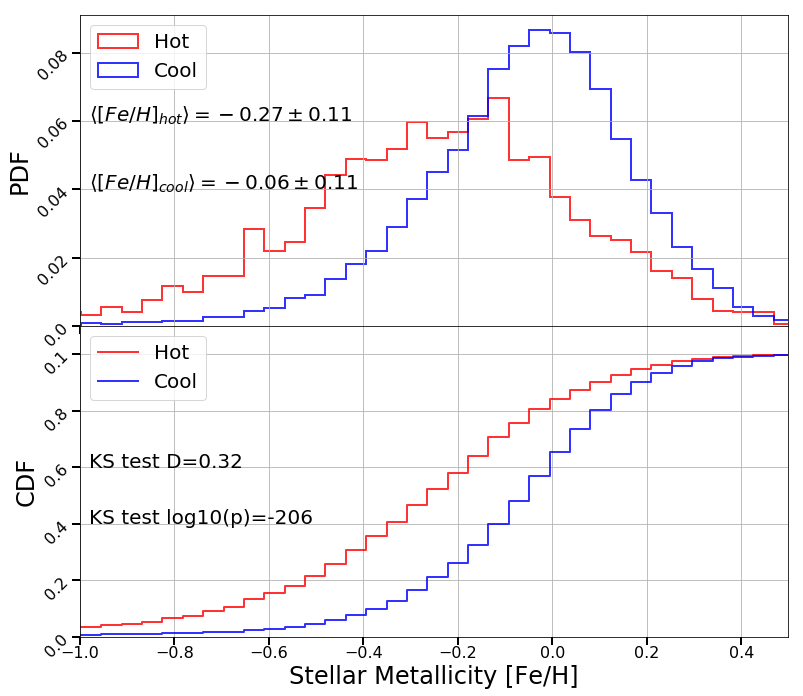

In [46]:
from scipy import stats
import statsmodels.api as sm

#plot mass-velocity correlation cdf and pdf
hot_feh=HOT_MET_LAMOST
cool_feh=COOL_MET_LAMOST

s1=stats.ks_2samp(hot_feh,cool_feh)

fig=plt.figure(figsize=(12,12))
ax1=plt.subplot(211)
bins=np.linspace(min(min(hot_feh),min(cool_feh)),max(max(hot_feh),max(cool_feh)),100)
#bins=np.linspace(-1,0.5,100)
weights1 = np.ones_like(hot_feh)/float(len(hot_feh))
plt.subplots_adjust(top=0.92, bottom=0.2, left=0.13, right=0.95, hspace=0,
                    wspace=0.35)


ax1.hist(hot_feh,bins,histtype="step",weights=weights1,color='red',linewidth=2,alpha=0.8,label='Hot')

weights2 = np.ones_like(cool_feh)/float(len(cool_feh))
ax1.hist(cool_feh,bins,histtype="step",weights=weights2,color='blue',linewidth=2,alpha=0.8,label='Cool')
ax1.grid(True)
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.text(-0.98,0.06,'$\langle [Fe/H]_{hot}\\rangle=-0.27 \pm 0.11$',fontsize=20)#,fontweight='bold')
ax1.text(-0.98,0.04,'$\langle [Fe/H]_{cool}\\rangle=-0.06 \pm 0.11$',fontsize=20)#,fontweight='bold')

ax1.tick_params(axis='both',direction='out',which='major',
                width=2,length=8,color='black',pad=1,labelsize=16,
               labelbottom=True, labeltop=False,labelleft=True,labelright=False, )
ax1.tick_params(axis='both',direction='out',which='minor',
                width=1,length=4,color='black',pad=1,labelsize=16,
               labelbottom=True, labeltop=False,labelleft=True,labelright=False, )

yticks = [0.00,0.02,0.04,0.06,0.08]
ylabels = [0.00,0.02,0.04,0.06,0.08]
ax1.set_yticks(yticks)
ax1.set_yticklabels(ylabels,rotation=45)


#ax1.set_xticks(hot_feh,color='blue',rotation=60)
ax1.legend(loc='upper left',fontsize=20)
ax1.set_ylabel("PDF",fontsize=24)
#ax1.set_xscale('log')
ax1.set_xlim(-1,0.5)

ax2=plt.subplot(212)
ecdf=sm.distributions.ECDF(hot_feh)
counts1=ecdf(bins)
ax2.step(bins,counts1,color='red',linewidth=2,alpha=0.8,label='Hot')#+'p='+'{:5f}'.format(s1[1]))
ecdf=sm.distributions.ECDF(cool_feh)
counts2=ecdf(bins)
ax2.step(bins,counts2,color='blue',linewidth=2,alpha=0.8,label='Cool')

ax2.text(-0.98,0.6,'KS test D=0.32',fontsize=20)#,fontweight='bold')
ax2.text(-0.98,0.4,'KS test log10(p)=-206',fontsize=20)#,fontweight='bold')

ax2.tick_params(axis='both',direction='out',which='major',
                width=2,length=8,color='black',pad=1,labelsize=16,
               labelbottom=True, labeltop=False,labelleft=True,labelright=False, )
ax2.tick_params(axis='both',direction='out',which='minor',
                width=1,length=4,color='black',pad=1,labelsize=16,
               labelbottom=True, labeltop=False,labelleft=True,labelright=False, )

yticks = [0.0,0.2,0.4,0.6,0.8,1.0]
ylabels = [0.0,0.2,0.4,0.6,0.8,0.1]
ax2.set_yticks(yticks)
ax2.set_yticklabels(ylabels,rotation=45)

ax2.set_xlabel("Stellar Metallicity [Fe/H]",fontsize=24)
ax2.set_ylabel("CDF",fontsize=24)
ax2.set_ylim(0,1.1)
ax2.grid(True)
ax2.legend(loc='upper left',fontsize=20)
#ax2.set_xscale('log')
ax2.set_xlim(-1,0.5)
#ax2.text('D = 0.1099')
plt.savefig('result/cool_hot_metallicity_LAMOST_DR4.png',dpi=300)

In [34]:
from scipy import stats
import statsmodels.api as sm

print(np.mean(hot_teff),np.mean(HOT_STAR['teffe_b2018']))
print(np.mean(cool_teff),np.mean(COOL_STAR['teffe_b2018']))

s1=stats.ks_2samp(hot_teff,cool_teff)
print(s1,np.log10(s1[1]))

5753.587447108604 198.67368527100544
5817.315682202738 199.6840197661898
Ks_2sampResult(statistic=0.0535427108301787, pvalue=4.787431974000349e-23) -22.319897383994846


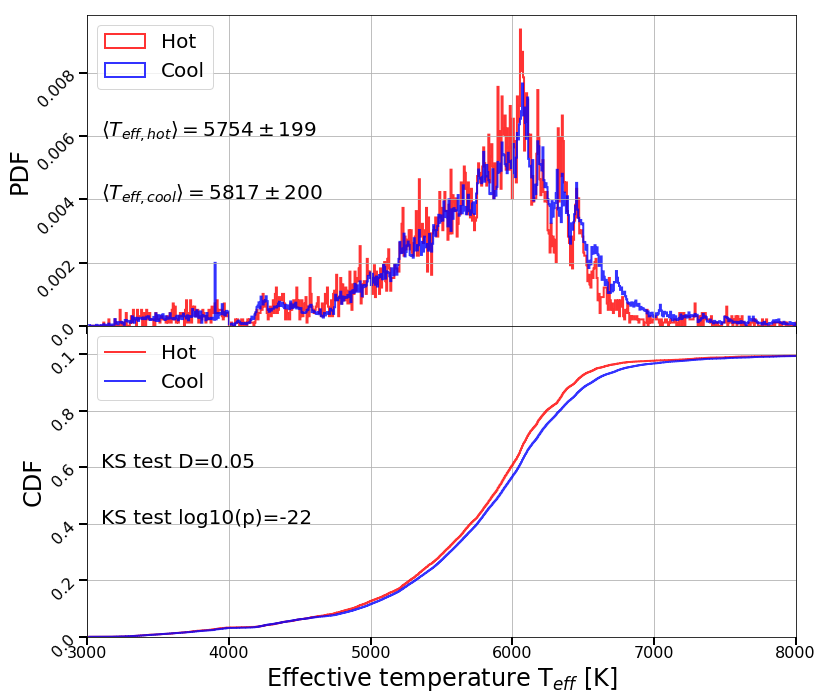

In [58]:
from scipy import stats
import statsmodels.api as sm

#plot mass-velocity correlation cdf and pdf

HOT_STAR=pd.read_csv('data/kepler_stellar_q17_add_dispersions_reduction_reduction_hot_2020.csv',sep=',')
COOL_STAR=pd.read_csv('data/kepler_stellar_q17_add_dispersions_reduction_reduction_cool_2020.csv',sep=',')

hot_teff=HOT_STAR['teff_b2018']

cool_teff=COOL_STAR['teff_b2018']

s1=stats.ks_2samp(hot_teff,cool_teff)

fig=plt.figure(figsize=(12,12))
ax1=plt.subplot(211)
bins=np.linspace(min(min(hot_teff),min(cool_teff)),max(max(hot_teff),max(cool_teff)),1000)
weights1 = np.ones_like(hot_teff)/float(len(hot_teff))
plt.subplots_adjust(top=0.92, bottom=0.2, left=0.13, right=0.95, hspace=0,
                    wspace=0.35)


ax1.hist(hot_teff,bins,histtype="step",weights=weights1,color='red',linewidth=2,alpha=0.8,label='Hot')

weights2 = np.ones_like(cool_teff)/float(len(cool_teff))
ax1.hist(cool_teff,bins,histtype="step",weights=weights2,color='blue',linewidth=2,alpha=0.8,label='Cool')
ax1.grid(True)
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.text(3100,0.006,'$\langle T_{eff,hot}\\rangle=5754 \pm 199$',fontsize=20)#,fontweight='bold')
ax1.text(3100,0.004,'$\langle T_{eff,cool}\\rangle=5817 \pm 200$',fontsize=20)#,fontweight='bold')

ax1.tick_params(axis='both',direction='out',which='major',
                width=2,length=8,color='black',pad=1,labelsize=16,
               labelbottom=True, labeltop=False,labelleft=True,labelright=False, )
ax1.tick_params(axis='both',direction='out',which='minor',
                width=1,length=4,color='black',pad=1,labelsize=16,
               labelbottom=True, labeltop=False,labelleft=True,labelright=False, )

yticks = [0.000,0.002,0.004,0.006,0.008]
ylabels = [0.000,0.002,0.004,0.006,0.008]
ax1.set_yticks(yticks)
ax1.set_yticklabels(ylabels,rotation=45)


#ax1.set_xticks(hot_feh,color='blue',rotation=60)
ax1.legend(loc='upper left',fontsize=20)
ax1.set_ylabel("PDF",fontsize=24)
#ax1.set_xscale('log')
ax1.set_xlim(3000,8000)

ax2=plt.subplot(212)
ecdf=sm.distributions.ECDF(hot_teff)
counts1=ecdf(bins)
ax2.step(bins,counts1,color='red',linewidth=2,alpha=0.8,label='Hot')#+'p='+'{:5f}'.format(s1[1]))
ecdf=sm.distributions.ECDF(cool_teff)
counts2=ecdf(bins)
ax2.step(bins,counts2,color='blue',linewidth=2,alpha=0.8,label='Cool')

ax2.text(3100,0.6,'KS test D=0.05',fontsize=20)#,fontweight='bold')
ax2.text(3100,0.4,'KS test log10(p)=-22',fontsize=20)#,fontweight='bold')

ax2.tick_params(axis='both',direction='out',which='major',
                width=2,length=8,color='black',pad=1,labelsize=16,
               labelbottom=True, labeltop=False,labelleft=True,labelright=False, )
ax2.tick_params(axis='both',direction='out',which='minor',
                width=1,length=4,color='black',pad=1,labelsize=16,
               labelbottom=True, labeltop=False,labelleft=True,labelright=False, )

yticks = [0.0,0.2,0.4,0.6,0.8,1.0]
ylabels = [0.0,0.2,0.4,0.6,0.8,0.1]
ax2.set_yticks(yticks)
ax2.set_yticklabels(ylabels,rotation=45)

ax2.set_xlabel("Effective temperature T$_{eff}$ [K]",fontsize=24)
ax2.set_ylabel("CDF",fontsize=24)
ax2.set_ylim(0,1.1)
ax2.grid(True)
ax2.legend(loc='upper left',fontsize=20)
#ax2.set_xscale('log')
ax2.set_xlim(3000,8000)
#ax2.text('D = 0.1099')
plt.savefig('result/cool_hot_TEFF_BERGER2018.png',dpi=300)

In [57]:
from scipy import stats
import statsmodels.api as sm

print(np.mean(hot_teff),np.std(hot_teff))
print(np.mean(cool_teff),np.std(cool_teff))

s1=stats.ks_2samp(hot_teff,cool_teff)
print(s1,np.log10(s1[1]))

0.9433828329639322 0.24411256483716232
1.002414436240556 0.2741660666031197
Ks_2sampResult(statistic=0.11932183328140311, pvalue=9.059859290577958e-113) -112.04287854733424


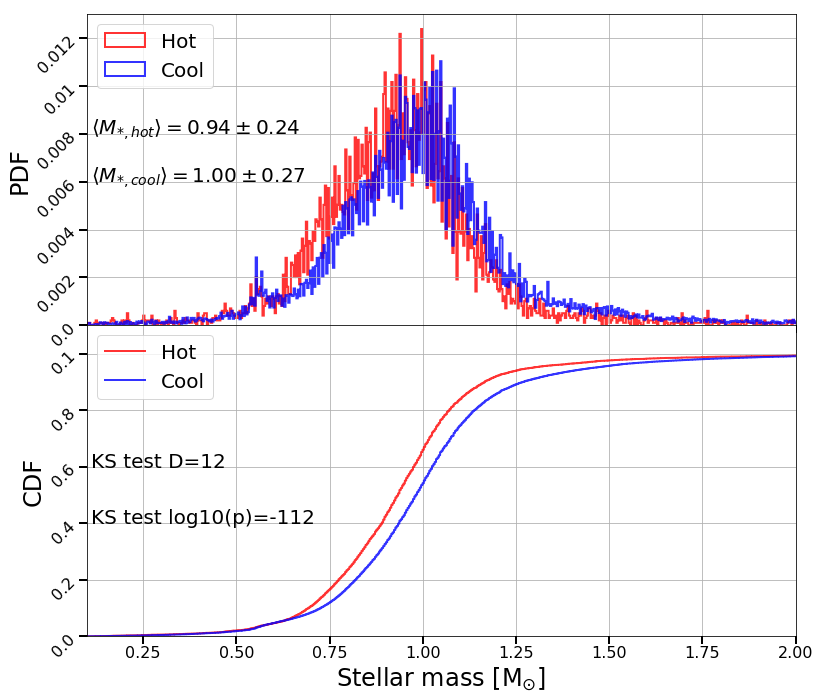

In [62]:
from scipy import stats
import statsmodels.api as sm

#plot mass-velocity correlation cdf and pdf

HOT_STAR=pd.read_csv('data/kepler_stellar_q17_add_dispersions_reduction_reduction_hot_2020.csv',sep=',')
COOL_STAR=pd.read_csv('data/kepler_stellar_q17_add_dispersions_reduction_reduction_cool_2020.csv',sep=',')

hot_teff=HOT_STAR['mass']

cool_teff=COOL_STAR['mass']

s1=stats.ks_2samp(hot_teff,cool_teff)

fig=plt.figure(figsize=(12,12))
ax1=plt.subplot(211)
bins=np.linspace(min(min(hot_teff),min(cool_teff)),max(max(hot_teff),max(cool_teff)),1000)
weights1 = np.ones_like(hot_teff)/float(len(hot_teff))
plt.subplots_adjust(top=0.92, bottom=0.2, left=0.13, right=0.95, hspace=0,
                    wspace=0.35)


ax1.hist(hot_teff,bins,histtype="step",weights=weights1,color='red',linewidth=2,alpha=0.8,label='Hot')

weights2 = np.ones_like(cool_teff)/float(len(cool_teff))
ax1.hist(cool_teff,bins,histtype="step",weights=weights2,color='blue',linewidth=2,alpha=0.8,label='Cool')
ax1.grid(True)
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.text(0.11,0.008,'$\langle M_{*,hot}\\rangle=0.94 \pm 0.24$',fontsize=20)#,fontweight='bold')
ax1.text(0.11,0.006,'$\langle M_{*,cool}\\rangle=1.00 \pm 0.27$',fontsize=20)#,fontweight='bold')

ax1.tick_params(axis='both',direction='out',which='major',
                width=2,length=8,color='black',pad=1,labelsize=16,
               labelbottom=True, labeltop=False,labelleft=True,labelright=False, )
ax1.tick_params(axis='both',direction='out',which='minor',
                width=1,length=4,color='black',pad=1,labelsize=16,
               labelbottom=True, labeltop=False,labelleft=True,labelright=False, )

yticks = [0.000,0.002,0.004,0.006,0.008,0.010,0.012]
ylabels = [0.000,0.002,0.004,0.006,0.008,0.010,0.012]
ax1.set_yticks(yticks)
ax1.set_yticklabels(ylabels,rotation=45)


#ax1.set_xticks(hot_feh,color='blue',rotation=60)
ax1.legend(loc='upper left',fontsize=20)
ax1.set_ylabel("PDF",fontsize=24)
#ax1.set_xscale('log')
ax1.set_xlim(0.1,2)

ax2=plt.subplot(212)
ecdf=sm.distributions.ECDF(hot_teff)
counts1=ecdf(bins)
ax2.step(bins,counts1,color='red',linewidth=2,alpha=0.8,label='Hot')#+'p='+'{:5f}'.format(s1[1]))
ecdf=sm.distributions.ECDF(cool_teff)
counts2=ecdf(bins)
ax2.step(bins,counts2,color='blue',linewidth=2,alpha=0.8,label='Cool')

ax2.text(0.11,0.6,'KS test D=12',fontsize=20)#,fontweight='bold')
ax2.text(0.11,0.4,'KS test log10(p)=-112',fontsize=20)#,fontweight='bold')

ax2.tick_params(axis='both',direction='out',which='major',
                width=2,length=8,color='black',pad=1,labelsize=16,
               labelbottom=True, labeltop=False,labelleft=True,labelright=False, )
ax2.tick_params(axis='both',direction='out',which='minor',
                width=1,length=4,color='black',pad=1,labelsize=16,
               labelbottom=True, labeltop=False,labelleft=True,labelright=False, )

yticks = [0.0,0.2,0.4,0.6,0.8,1.0]
ylabels = [0.0,0.2,0.4,0.6,0.8,0.1]
ax2.set_yticks(yticks)
ax2.set_yticklabels(ylabels,rotation=45)

ax2.set_xlabel("Stellar mass [M$_{\odot}$]",fontsize=24)
ax2.set_ylabel("CDF",fontsize=24)
ax2.set_ylim(0,1.1)
ax2.grid(True)
ax2.legend(loc='upper left',fontsize=20)
#ax2.set_xscale('log')
ax2.set_xlim(0.1,2)
#ax2.text('D = 0.1099')
plt.savefig('result/cool_hot_mass_BERGER2018.png',dpi=300)